# Dental Radiography Analysis with PyTorch

This project uses PyTorch to build and train a model to detect cavities, fillings, impacted teeth, and implants in dental radiographs. The notebook is organized into five parts:

1.  **Initial Model Training:** This part covers the initial training of the model.
2.  **Weighted Sampling:** This part covers the use of weighted sampling to improve the model's performance.
3.  **Focal Loss:** This part covers the use of focal loss to improve the model's performance.
4.  **Hard Negative Mining:** This part covers the use of hard negative mining to improve the model's performance.
5.  **Model Ensembling:** This part covers the use of model ensembling to improve the model's performance.

## Dataset : [Dental-Radiography](https://www.kaggle.com/datasets/imtkaggleteam/dental-radiography/data)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Initial Model Training

## 1.1. Dataset and Dependencies

### 1.1.1. Imports and Setup

In [ ]:
import os, cv2, torch, pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    fasterrcnn_mobilenet_v3_large_fpn
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class labels
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
class2idx = {c: i for i, c in enumerate(CLASSES)}
num_classes = len(CLASSES)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 1.1.2. Paths

In [ ]:
BASE_DIR = "/content/drive/MyDrive/My Datasets"
ENHANCED_DIR = os.path.join(BASE_DIR, "data_enhanced")
TRAIN_DIR = os.path.join(ENHANCED_DIR, "train")
VALID_DIR = os.path.join(ENHANCED_DIR, "valid")

### 1.1.3. Annotation Loader

In [ ]:
def load_annotations(csv_path, images_dir, class2idx):
    df = pd.read_csv(csv_path)
    annots = {}
    for _, row in df.iterrows():
        fn = row['filename']
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        lbl = class2idx[row['class']]
        if bbox[2] <= bbox[0] or bbox[3] <= bbox[1]:
            continue
        annots.setdefault(fn, {'boxes': [], 'labels': []})
        annots[fn]['boxes'].append(bbox)
        annots[fn]['labels'].append(lbl)

    dataset = []
    for fn, data in annots.items():
        img_path = os.path.join(images_dir, fn)
        dataset.append({
            'image_path': img_path,
            'boxes': torch.tensor(data['boxes'], dtype=torch.float32),
            'labels': torch.tensor(data['labels'], dtype=torch.int64),
        })
    return dataset

### 1.1.4. Dataset Class

In [ ]:
class DentalXrayDataset(Dataset):
    def __init__(self, data_list, transforms=None):
        self.data = data_list
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = cv2.imread(item['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ✅ Manually normalize before Albumentations
        image = image.astype('float32') / 255.0

        boxes = item['boxes']
        labels = item['labels']
        bboxes = boxes.tolist()
        labels = labels.tolist()

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
            image = transformed['image']
            boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.tensor(transformed['labels'], dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
        }

        return image, target

### 1.1.5. Transforms

In [ ]:
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        ToTensorV2()  # 🔥 this converts to float32 and scales to [0–1]
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.3))

def get_valid_transforms():
    return A.Compose([
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## 1.2. Data Loading and Preprocessing

### 1.2.1. Load and Tag Training Data

In [ ]:
train_list = load_annotations(os.path.join(TRAIN_DIR, '_annotations.csv'), TRAIN_DIR, class2idx)
is_cavity = torch.tensor([any(l == class2idx['Cavity'] for l in item['labels']) for item in train_list])
is_impacted = torch.tensor([any(l == class2idx['Impacted Tooth'] for l in item['labels']) for item in train_list])

# Weighted sampling
weights = torch.ones(len(train_list))
weights[is_cavity] += 4
weights[is_impacted] += 1
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

### 1.2.2. Datasets and DataLoaders

In [ ]:
train_dataset = DentalXrayDataset(train_list, transforms=get_train_transforms())
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler, collate_fn=lambda x: tuple(zip(*x)))

valid_list = load_annotations(os.path.join(VALID_DIR, '_annotations.csv'), VALID_DIR, class2idx)
valid_dataset = DentalXrayDataset(valid_list, transforms=get_valid_transforms())
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


###1.2.3. Preprocessing

✅ Image shape: torch.Size([3, 256, 512])
✅ Image dtype: torch.uint8
✅ Min/Max pixel: 0 / 255


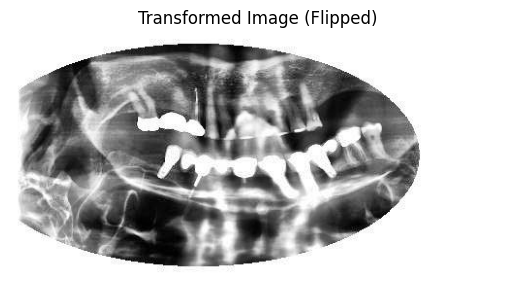

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import torch

# Load one raw image
sample_path = train_list[0]['image_path']
image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Sample boxes/labels
boxes = train_list[0]['boxes'].tolist()
labels = train_list[0]['labels'].tolist()

# Apply transform
transform = A.Compose([
    A.HorizontalFlip(p=1.0),  # force flip just to be sure it's working
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transformed = transform(image=image, bboxes=boxes, labels=labels)

# Get result
img_tensor = transformed['image']
print("✅ Image shape:", img_tensor.shape)
print("✅ Image dtype:", img_tensor.dtype)
print("✅ Min/Max pixel:", img_tensor.min().item(), "/", img_tensor.max().item())

# Optional: display it
plt.imshow(img_tensor.permute(1, 2, 0).cpu())
plt.title("Transformed Image (Flipped)")
plt.axis("off")
plt.show()


## 1.3. Model Definition

### 1.3.1. Build Models (ResNet50 + MobileNetV3)

In [ ]:
model_resnet = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features_r = model_resnet.roi_heads.box_predictor.cls_score.in_features
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features_r, num_classes)
model_resnet.to(device)

model_mobilenet = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
in_features_m = model_mobilenet.roi_heads.box_predictor.cls_score.in_features
model_mobilenet.roi_heads.box_predictor = FastRCNNPredictor(in_features_m, num_classes)
model_mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 169MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 162MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

### 1.3.2. Define Weighted Loss Function

In [ ]:
cls_weights = torch.tensor([1.0, 5.0, 1.0, 2.0, 1.0], device=device)

def fastrcnn_loss_weighted(class_logits, box_regression, labels, regression_targets):
    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)
    classification_loss = F.cross_entropy(class_logits, labels, weight=cls_weights)
    sampled_pos_inds = torch.where(labels > 0)[0]
    if sampled_pos_inds.numel() == 0:
        box_loss = torch.tensor(0.).to(class_logits.device)
    else:
        box_loss = F.smooth_l1_loss(
            box_regression[sampled_pos_inds],
            regression_targets[sampled_pos_inds],
            beta=1.0,
            reduction='sum'
        ) / labels.numel()
    return classification_loss, box_loss

model_resnet.roi_heads.fastrcnn_loss = fastrcnn_loss_weighted
model_mobilenet.roi_heads.fastrcnn_loss = fastrcnn_loss_weighted

### 1.3.3. Optimizers

In [ ]:
optimizer_r = torch.optim.SGD(model_resnet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer_m = torch.optim.SGD(model_mobilenet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


## 1.4. Training

### 1.4.1. Training Loop (15 Epochs)

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")

    model_resnet.train()
    model_mobilenet.train()

    total_loss_r = 0.0
    total_loss_m = 0.0

    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # --- ResNet ---
        loss_dict_r = model_resnet(imgs, targets)
        loss_r = sum(loss for loss in loss_dict_r.values())
        optimizer_r.zero_grad()
        loss_r.backward()
        optimizer_r.step()
        total_loss_r += loss_r.item()

        # --- MobileNet ---
        loss_dict_m = model_mobilenet(imgs, targets)
        loss_m = sum(loss for loss in loss_dict_m.values())
        optimizer_m.zero_grad()
        loss_m.backward()
        optimizer_m.step()
        total_loss_m += loss_m.item()

    avg_loss_r = total_loss_r / len(train_loader)
    avg_loss_m = total_loss_m / len(train_loader)
    print(f"📉 ResNet Avg Loss: {avg_loss_r:.4f} | 📉 MobileNet Avg Loss: {avg_loss_m:.4f}")



🔁 Epoch 1/15
📉 ResNet Avg Loss: 0.8682 | 📉 MobileNet Avg Loss: 0.8906

🔁 Epoch 2/15
📉 ResNet Avg Loss: 0.6464 | 📉 MobileNet Avg Loss: 0.7387

🔁 Epoch 3/15
📉 ResNet Avg Loss: 0.5594 | 📉 MobileNet Avg Loss: 0.7057

🔁 Epoch 4/15
📉 ResNet Avg Loss: 0.5351 | 📉 MobileNet Avg Loss: 0.6959

🔁 Epoch 5/15
📉 ResNet Avg Loss: 0.5274 | 📉 MobileNet Avg Loss: 0.6851

🔁 Epoch 6/15
📉 ResNet Avg Loss: 0.4924 | 📉 MobileNet Avg Loss: 0.6774

🔁 Epoch 7/15
📉 ResNet Avg Loss: 0.4678 | 📉 MobileNet Avg Loss: 0.6619

🔁 Epoch 8/15
📉 ResNet Avg Loss: 0.4513 | 📉 MobileNet Avg Loss: 0.6650

🔁 Epoch 9/15
📉 ResNet Avg Loss: 0.4518 | 📉 MobileNet Avg Loss: 0.6618

🔁 Epoch 10/15
📉 ResNet Avg Loss: 0.4560 | 📉 MobileNet Avg Loss: 0.6454

🔁 Epoch 11/15
📉 ResNet Avg Loss: 0.4400 | 📉 MobileNet Avg Loss: 0.6620

🔁 Epoch 12/15
📉 ResNet Avg Loss: 0.4189 | 📉 MobileNet Avg Loss: 0.6663

🔁 Epoch 13/15
📉 ResNet Avg Loss: 0.3991 | 📉 MobileNet Avg Loss: 0.6473

🔁 Epoch 14/15
📉 ResNet Avg Loss: 0.3938 | 📉 MobileNet Avg Loss: 0.6492



## 1.5. Saving and Loading

### 1.5.1. Saving

In [ ]:
# ────────────────────────────────────────────────────────────────
# 1️⃣2️⃣ Save Trained Models
# ────────────────────────────────────────────────────────────────
SAVE_DIR = os.path.join(BASE_DIR, "data_enhanced/models")
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(model_resnet.state_dict(), os.path.join(SAVE_DIR, "fasterrcnn_resnet50_weighted.pth"))
torch.save(model_mobilenet.state_dict(), os.path.join(SAVE_DIR, "fasterrcnn_mobilenetv3_weighted.pth"))

print("✅ Models saved successfully.")


✅ Models saved successfully.


### 1.5.2. Loading the trained models

In [9]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Class count
num_classes = 5  # __background__ + 4 dental classes

# ────────────────────────────────────────────────────────
# 🔁 Load Faster R-CNN with ResNet50
# ────────────────────────────────────────────────────────
model_resnet = fasterrcnn_resnet50_fpn(weights=None)  # not using COCO weights
in_features_r = model_resnet.roi_heads.box_predictor.cls_score.in_features
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features_r, num_classes)

resnet_path = "/content/drive/My Drive/My Datasets/data_enhanced/models/fasterrcnn_resnet50_weighted.pth"
model_resnet.load_state_dict(torch.load(resnet_path, map_location=device))
model_resnet.to(device).eval()

# ────────────────────────────────────────────────────────
# 🔁 Load Faster R-CNN with MobileNetV3
# ────────────────────────────────────────────────────────
model_mobilenet = fasterrcnn_mobilenet_v3_large_fpn(weights=None)
in_features_m = model_mobilenet.roi_heads.box_predictor.cls_score.in_features
model_mobilenet.roi_heads.box_predictor = FastRCNNPredictor(in_features_m, num_classes)

mobilenet_path = "/content/drive/My Drive/My Datasets/data_enhanced/models/fasterrcnn_mobilenetv3_weighted.pth"
model_mobilenet.load_state_dict(torch.load(mobilenet_path, map_location=device))
model_mobilenet.to(device).eval()


Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


File not found: /content/drive/My Drive/My Datasets/data_enhanced/models/fasterrcnn_resnet50_weighted.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s] 


File not found: /content/drive/My Drive/My Datasets/data_enhanced/models/fasterrcnn_mobilenetv3_weighted.pth


## 1.6. Evaluation

### 1.6.1. Metrices


Classification Report — ResNet50


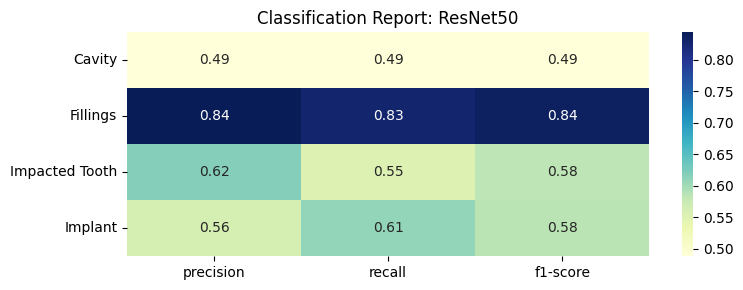

Overall Accuracy (ResNet50): 0.75 | Error: 0.25


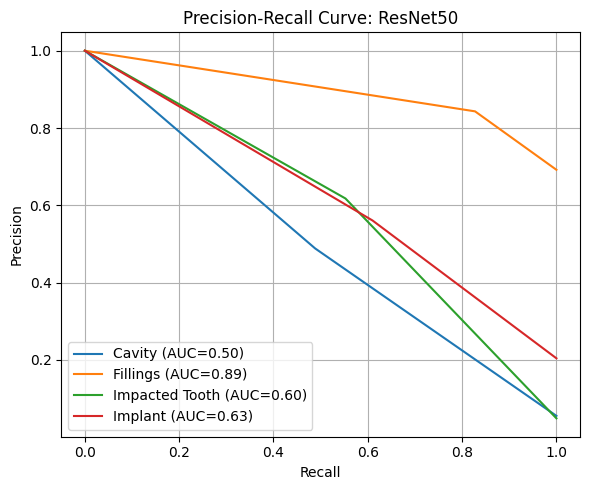

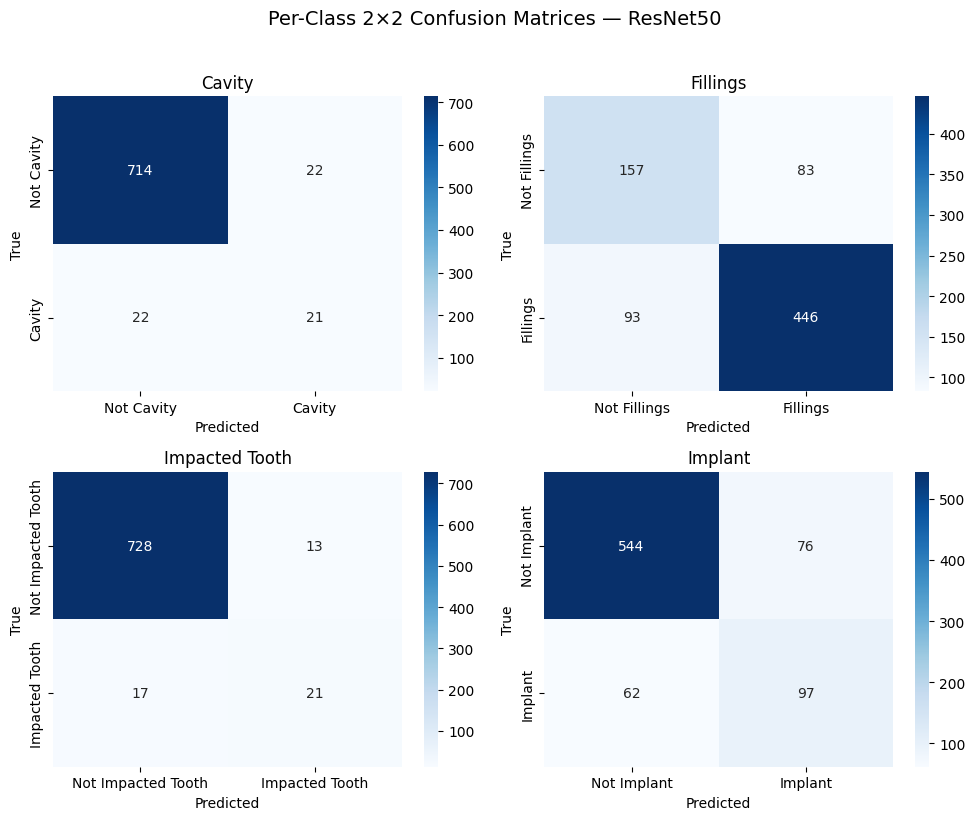


Classification Report — MobileNetV3


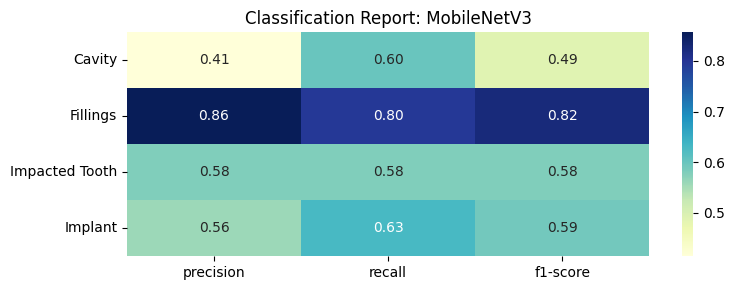

Overall Accuracy (MobileNetV3): 0.74 | Error: 0.26


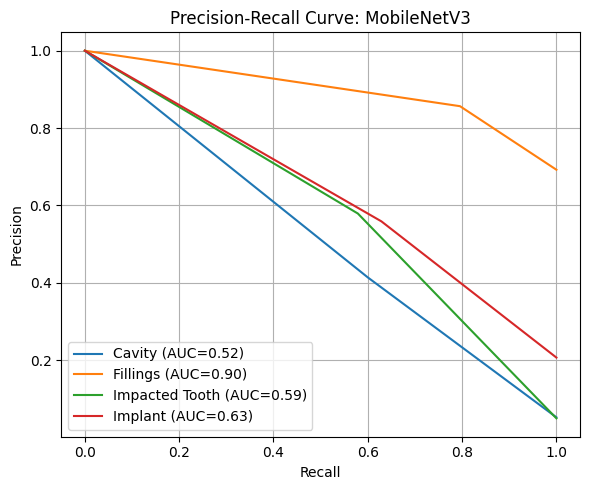

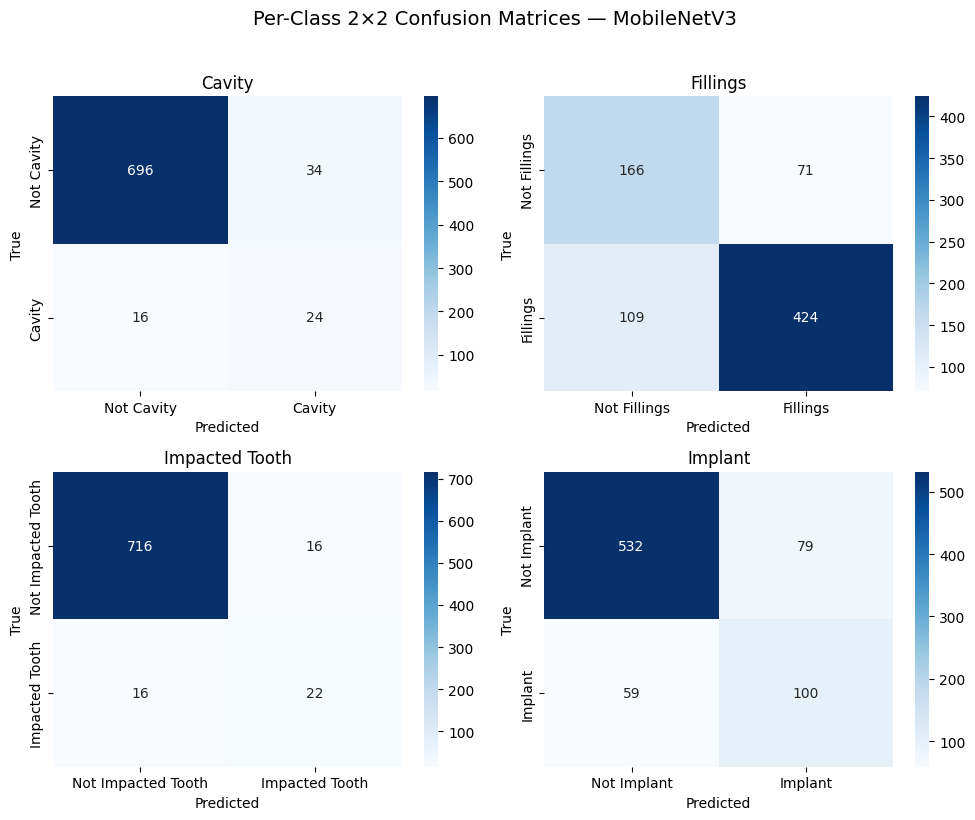

In [ ]:
def evaluate_model(model, model_name):
    # setup
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for i in range(len(images)):
                pred_labels = outputs[i]['labels'].cpu().numpy().tolist()
                true_labels = targets[i]['labels'].cpu().numpy().tolist()
                n = min(len(pred_labels), len(true_labels))
                all_preds.extend(pred_labels[:n])
                all_targets.extend(true_labels[:n])

    # classification report
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print(f"\nClassification Report — {model_name}")
    report = classification_report(all_targets, all_preds, labels=list(range(1, len(CLASSES))), target_names=CLASSES[1:], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 3))
    sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Classification Report: {model_name}")
    plt.tight_layout()
    plt.show()

    # accuracy
    acc = accuracy_score(all_targets, all_preds)
    print(f"Overall Accuracy ({model_name}): {acc:.2f} | Error: {1 - acc:.2f}")

    # precision-recall curve
    plt.figure(figsize=(6, 5))
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx+1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx+1 else 0 for p in all_preds])
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{cls_name} (AUC={pr_auc:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True)
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2x2 confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx + 1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx + 1 else 0 for p in all_preds])
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape != (2, 2): cm = np.array([[0, 0], [0, 0]])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"Not {cls_name}", cls_name],
                    yticklabels=[f"Not {cls_name}", cls_name],
                    ax=axes[idx])
        axes[idx].set_title(f"{cls_name}")
        axes[idx].set_xlabel("Predicted"); axes[idx].set_ylabel("True")
    plt.suptitle(f"Per-Class 2×2 Confusion Matrices — {model_name}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

evaluate_model(model_resnet, "ResNet50")
evaluate_model(model_mobilenet, "MobileNetV3")



### 1.6.2. Testing for single image


📸 Image: 0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg
✅ Ground Truth Labels     : ['Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings']
🔵 ResNet Predicted Labels : ['Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings', 'Fillings']


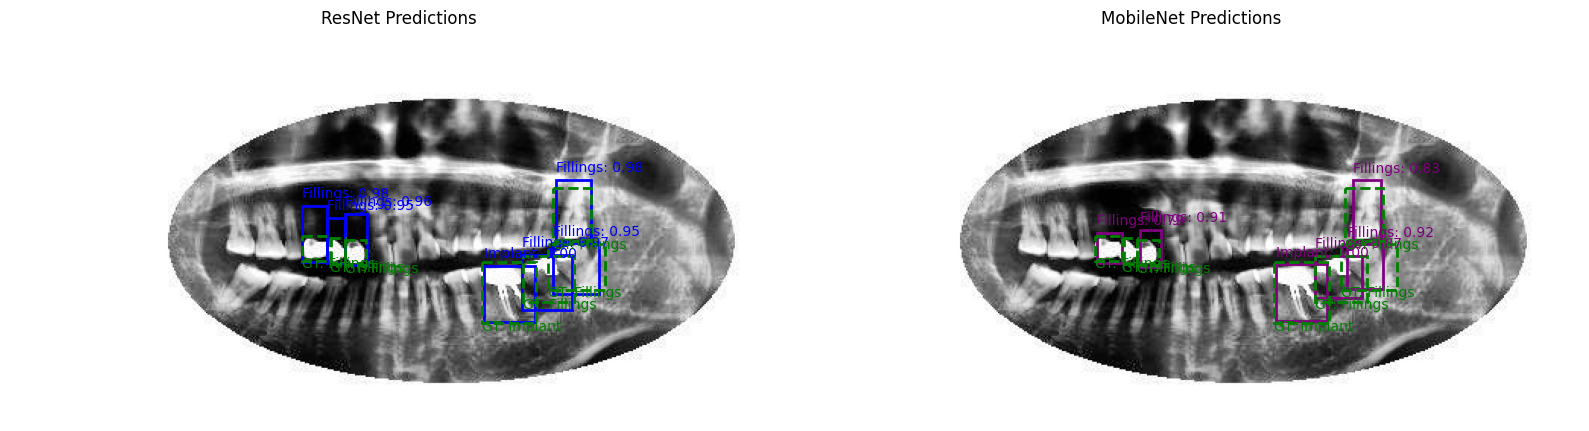


📸 Image: 0151_jpg.rf.5b81ded715693313866503d5a4da1639.jpg
✅ Ground Truth Labels     : ['Cavity', 'Cavity']
🔵 ResNet Predicted Labels : ['Cavity', 'Cavity', 'Cavity']
🟣 MobileNet Predicted Labels: ['Cavity', 'Cavity', 'Cavity']


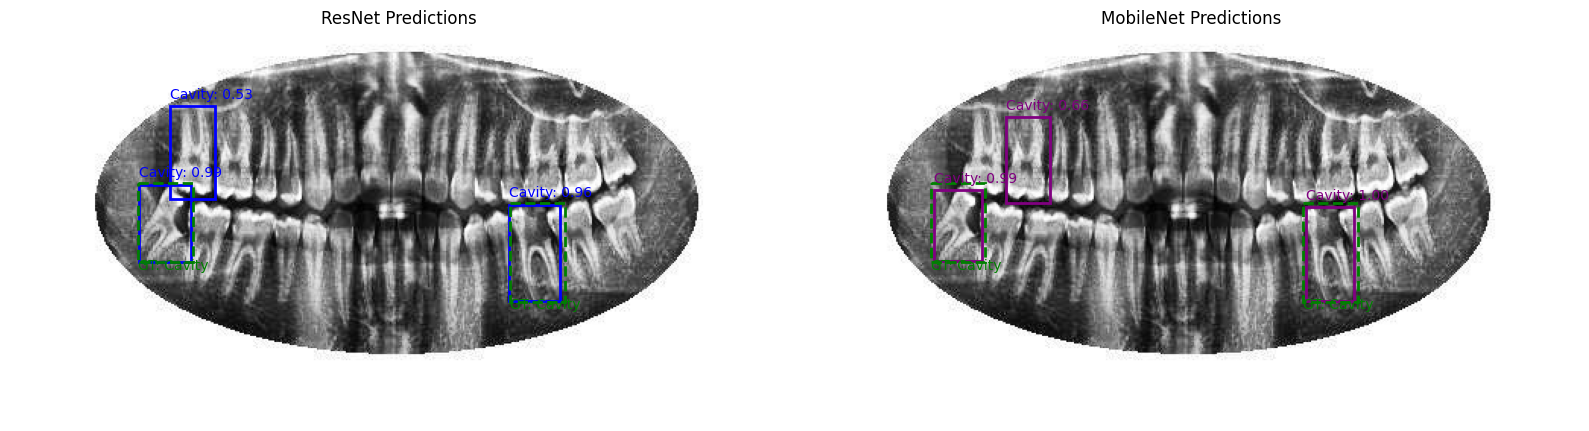


📸 Image: 0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg
✅ Ground Truth Labels     : ['Fillings', 'Fillings', 'Fillings']
🔵 ResNet Predicted Labels : ['Fillings', 'Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Fillings', 'Fillings']


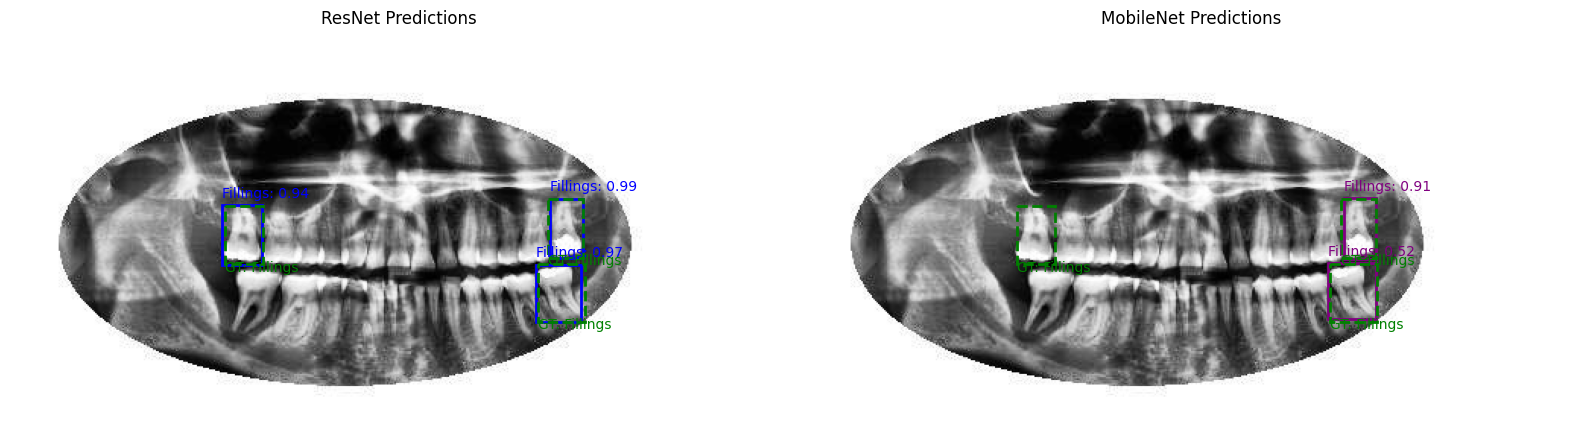


📸 Image: 0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg
✅ Ground Truth Labels     : ['Fillings', 'Fillings', 'Fillings']
🔵 ResNet Predicted Labels : ['Fillings', 'Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Fillings', 'Fillings']


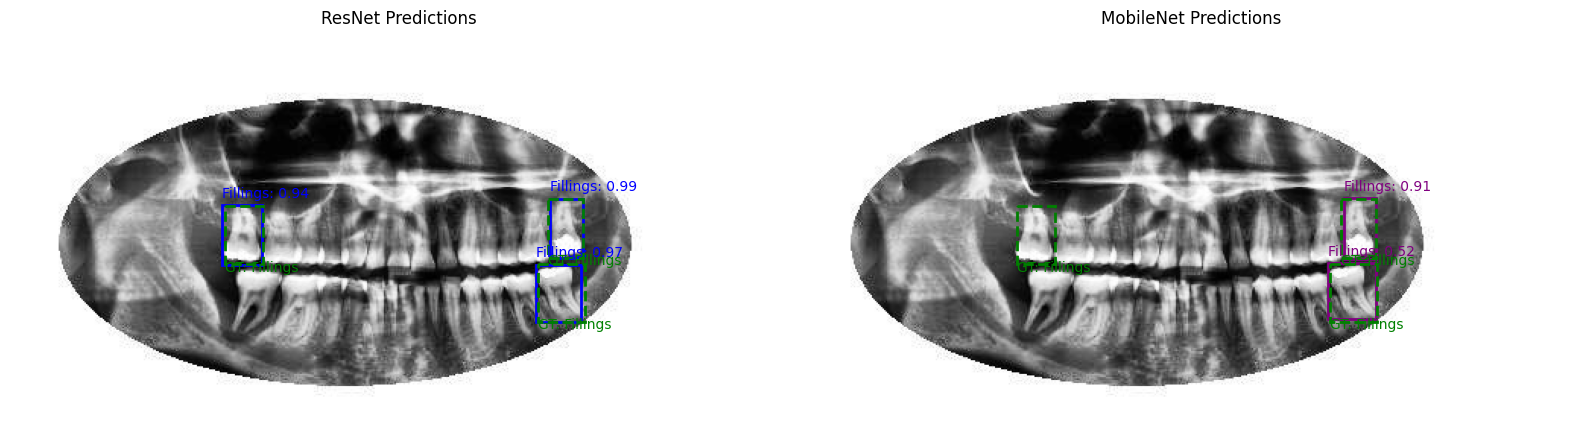


📸 Image: 0529_jpg.rf.d3cb17dddc3e9efd85e48c386feca1f2.jpg
✅ Ground Truth Labels     : ['Impacted Tooth']
🔵 ResNet Predicted Labels : ['Impacted Tooth']
🟣 MobileNet Predicted Labels: ['Impacted Tooth']


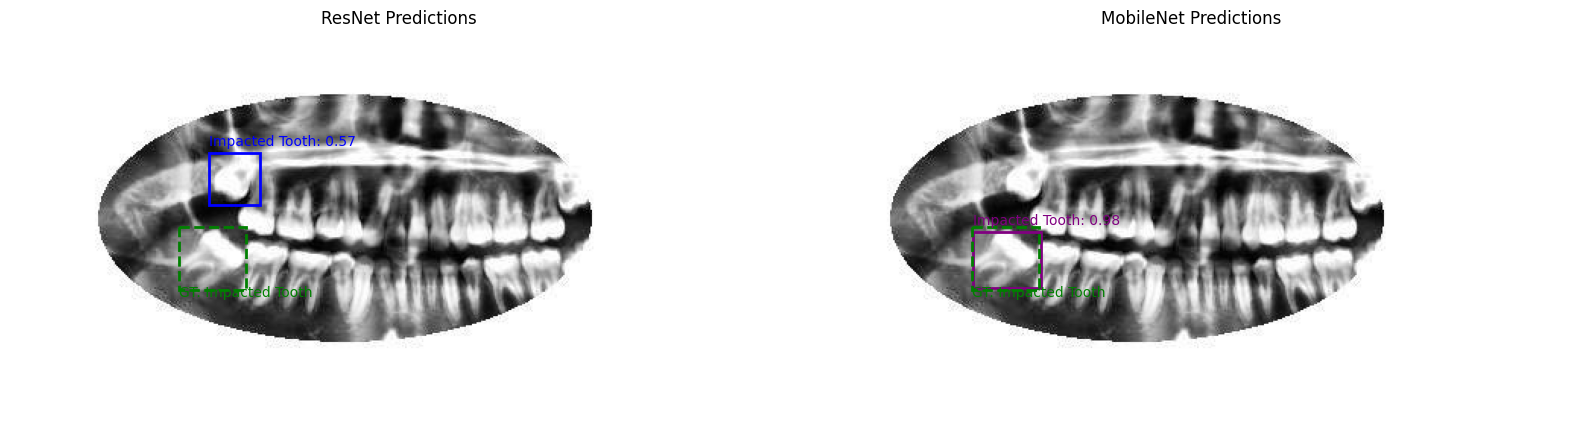

In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# 📌 Adjust class names
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']

# 📁 Paths
ANNOTATION_CSV = "/content/drive/MyDrive/My Datasets/data_enhanced/test/_annotations.csv"
IMAGE_DIR = "/content/drive/MyDrive/My Datasets/data_enhanced/test"
SAVE_DIR = "/content/drive/MyDrive/My Datasets/data_enhanced/models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load annotations CSV
df = pd.read_csv(ANNOTATION_CSV)

# 🔁 Preprocess image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(img), img  # tensor, PIL

# 📦 Get ground truth
def get_ground_truth(image_name):
    rows = df[df['filename'] == image_name]
    gts = []
    for _, row in rows.iterrows():
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        label = row['class']
        gts.append({'bbox': bbox, 'label': label})
    return gts

# 🔄 Compare both models
def compare_models_on_image(image_name):
    image_path = os.path.join(IMAGE_DIR, image_name)
    ground_truth = get_ground_truth(image_name)

    # Run predictions
    img_tensor, img_pil = load_image(image_path)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        pred_resnet = model_resnet([img_tensor])[0]
        pred_mobilenet = model_mobilenet([img_tensor])[0]

    # Extract predicted classes with scores > 0.5
    pred_resnet_labels = [CLASSES[label] for label, score in zip(pred_resnet['labels'], pred_resnet['scores']) if score > 0.5]
    pred_mobilenet_labels = [CLASSES[label] for label, score in zip(pred_mobilenet['labels'], pred_mobilenet['scores']) if score > 0.5]
    gt_labels = [obj['label'] for obj in ground_truth]

    # Print comparison
    print("\n📸 Image:", image_name)
    print("✅ Ground Truth Labels     :", gt_labels)
    print("🔵 ResNet Predicted Labels :", pred_resnet_labels)
    print("🟣 MobileNet Predicted Labels:", pred_mobilenet_labels)

    # Visualize predictions
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    titles = ['ResNet Predictions', 'MobileNet Predictions']
    models = [pred_resnet, pred_mobilenet]
    colors = ['blue', 'purple']

    for ax, pred, title, color in zip(axs, models, titles, colors):
        ax.imshow(img_pil.copy())

        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score < 0.5:
                continue
            x1, y1, x2, y2 = box.cpu()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{CLASSES[label]}: {score:.2f}", color=color, fontsize=10)

        # Ground truth boxes
        for obj in ground_truth:
            x1, y1, x2, y2 = obj['bbox']
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y2 + 5, f"GT: {obj['label']}", color='green', fontsize=10)

        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# 🔍 Test Images
compare_models_on_image("0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg")
compare_models_on_image("0151_jpg.rf.5b81ded715693313866503d5a4da1639.jpg")
compare_models_on_image("0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg")
compare_models_on_image("0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg")
compare_models_on_image("0529_jpg.rf.d3cb17dddc3e9efd85e48c386feca1f2.jpg")

# Part 2: Weighted Sampling

## 2.1. Mount Google Drive and Set Paths

In [11]:
from google.colab import drive
import os

# 📂 Mount your drive
drive.mount('/content/drive')

# 📁 Define paths
BASE_DIR = "/content/drive/MyDrive/My Datasets"
ENHANCED_DIR = os.path.join(BASE_DIR, "data_enhanced")
MODEL_SAVE_DIR = os.path.join(ENHANCED_DIR, "models")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.2. Imports and Setup

In [13]:
import torch
import torchvision
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    fasterrcnn_mobilenet_v3_large_fpn
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.transforms import functional as F
from PIL import Image
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class names
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
class2idx = {cls: i for i, cls in enumerate(CLASSES)}
num_classes = len(CLASSES)


## 2.3. Dataset and Transforms

In [16]:
class DentalXrayDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, transforms=None):
        self.data = data_list
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(item['image_path']).convert("RGB")
        boxes = item['boxes']
        labels = item['labels']

        keep = [i for i, box in enumerate(boxes) if box[2] > box[0] and box[3] > box[1]]
        if not keep:
            boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
            labels = torch.tensor([0], dtype=torch.int64)
        else:
            boxes = boxes[keep]
            labels = labels[keep]

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((boxes.shape[0],), dtype=torch.int64)
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return F.to_tensor(img), target

def get_transforms(train=True):
    def _transform(img, target):
        if train and torch.rand(1) < 0.5:
            img = F.hflip(img)
            w, _ = img.size
            boxes = target['boxes']
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target['boxes'] = boxes
        return img, target
    return _transform

def load_annotations(csv_path, img_dir, class2idx):
    df = pd.read_csv(csv_path)
    annots = {}
    for _, row in df.iterrows():
        fn = row['filename']
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        label = class2idx[row['class']]
        if bbox[2] <= bbox[0] or bbox[3] <= bbox[1]:
            continue
        annots.setdefault(fn, {'boxes': [], 'labels': []})
        annots[fn]['boxes'].append(bbox)
        annots[fn]['labels'].append(label)
    dataset = []
    for fn, data in annots.items():
        dataset.append({
            'image_path': os.path.join(img_dir, fn),
            'boxes': torch.tensor(data['boxes'], dtype=torch.float32),
            'labels': torch.tensor(data['labels'], dtype=torch.int64),
        })
    return dataset


## 2.4. Build Train Loader with Adjusted Sampling

In [17]:
# Load data
train_csv = os.path.join(ENHANCED_DIR, "train/_annotations.csv")
train_dir = os.path.join(ENHANCED_DIR, "train")
train_list = load_annotations(train_csv, train_dir, class2idx)

# Compute sampling weights
is_cavity = [any(lbl == 1 for lbl in item['labels']) for item in train_list]
is_impacted = [any(lbl == 3 for lbl in item['labels']) for item in train_list]

weights = torch.ones(len(train_list), dtype=torch.float32)
weights += 2.0 * torch.tensor(is_cavity, dtype=torch.float32)
weights += 0.5 * torch.tensor(is_impacted, dtype=torch.float32)

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Build dataset and loader
train_dataset = DentalXrayDataset(train_list, transforms=get_transforms(train=True))
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler, collate_fn=lambda x: tuple(zip(*x)))


## 2.5. Build Models (ResNet50 & MobileNetV3)

In [ ]:
def build_model(base='resnet'):
    if base == 'resnet':
        model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
    else:
        model = fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

model_resnet = build_model('resnet')
model_mobilenet = build_model('mobilenet')

optimizer_r = torch.optim.SGD(model_resnet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer_m = torch.optim.SGD(model_mobilenet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


## 2.6. Training

In [ ]:
num_epochs = 7

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")

    model_resnet.train()
    model_mobilenet.train()

    total_loss_r = 0.0
    total_loss_m = 0.0

    for imgs, targets in train_loader:
        imgs = [img.to(device).float() for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # ResNet
        try:
            loss_dict_r = model_resnet(imgs, targets)
            loss_r = sum(loss for loss in loss_dict_r.values())
            optimizer_r.zero_grad()
            loss_r.backward()
            optimizer_r.step()
            total_loss_r += loss_r.item()
        except Exception as e:
            print("⚠️ ResNet error:", e)

        # MobileNet
        try:
            loss_dict_m = model_mobilenet(imgs, targets)
            loss_m = sum(loss for loss in loss_dict_m.values())
            optimizer_m.zero_grad()
            loss_m.backward()
            optimizer_m.step()
            total_loss_m += loss_m.item()
        except Exception as e:
            print("⚠️ MobileNet error:", e)

    avg_loss_r = total_loss_r / len(train_loader)
    avg_loss_m = total_loss_m / len(train_loader)
    print(f"📉 ResNet Avg Loss: {avg_loss_r:.4f} | 📉 MobileNet Avg Loss: {avg_loss_m:.4f}")



🔁 Epoch 1/7
📉 ResNet Avg Loss: 0.7425 | 📉 MobileNet Avg Loss: 0.8193

🔁 Epoch 2/7
📉 ResNet Avg Loss: 0.4733 | 📉 MobileNet Avg Loss: 0.6534

🔁 Epoch 3/7
📉 ResNet Avg Loss: 0.3746 | 📉 MobileNet Avg Loss: 0.6358

🔁 Epoch 4/7
📉 ResNet Avg Loss: 0.3572 | 📉 MobileNet Avg Loss: 0.5999

🔁 Epoch 5/7
📉 ResNet Avg Loss: 0.3136 | 📉 MobileNet Avg Loss: 0.5726

🔁 Epoch 6/7
📉 ResNet Avg Loss: 0.3123 | 📉 MobileNet Avg Loss: 0.5682

🔁 Epoch 7/7
📉 ResNet Avg Loss: 0.2710 | 📉 MobileNet Avg Loss: 0.5674


## 2.7. Saving

In [ ]:
torch.save(model_resnet.state_dict(), os.path.join(MODEL_SAVE_DIR, "fasterrcnn_resnet50_weighted_v2.pth"))
torch.save(model_mobilenet.state_dict(), os.path.join(MODEL_SAVE_DIR, "fasterrcnn_mobilenetv3_weighted_v2.pth"))

print("✅ Models saved successfully.")


✅ Models saved successfully.


## 2.8. Loading

In [14]:
def load_model(path, base='resnet'):
    if base == 'resnet':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    else:
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=None)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device).eval()
    return model

# Load ResNet50 v2
model_resnet = load_model(
    path=f"{MODEL_SAVE_DIR}/fasterrcnn_resnet50_weighted_v2.pth",
    base="resnet"
)

# Load MobileNetV3 v2
model_mobilenet = load_model(
    path=f"{MODEL_SAVE_DIR}/fasterrcnn_mobilenetv3_weighted_v2.pth",
    base="mobilenet"
)


## 2.9. Evaluation

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load validation data
val_csv = os.path.join(ENHANCED_DIR, "valid/_annotations.csv")
val_dir = os.path.join(ENHANCED_DIR, "valid")
val_list = load_annotations(val_csv, val_dir, class2idx)
val_dataset = DentalXrayDataset(val_list, transforms=get_transforms(train=False))
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [19]:
def evaluate_model(model, model_name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                pred_labels = outputs[i]['labels'].cpu().numpy().tolist()
                true_labels = targets[i]['labels'].cpu().numpy().tolist()
                n = min(len(pred_labels), len(true_labels))
                all_preds.extend(pred_labels[:n])
                all_targets.extend(true_labels[:n])

    print(f"Classification Report — {model_name}")
    report = classification_report(all_targets, all_preds, labels=list(range(1, len(CLASSES))), target_names=CLASSES[1:], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 3))
    sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Classification Report: {model_name}")
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(all_targets, all_preds)
    print(f"Overall Accuracy: {acc:.2f} | Error: {(1 - acc):.2f}")

    # PR Curve
    plt.figure(figsize=(6, 5))
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx+1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx+1 else 0 for p in all_preds])
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{cls_name} (AUC={pr_auc:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True)
    plt.title(f"PR Curve — {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2x2 Confusion Matrix per class
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx + 1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx + 1 else 0 for p in all_preds])
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape != (2, 2): cm = np.array([[0, 0], [0, 0]])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"Not {cls_name}", cls_name],
                    yticklabels=[f"Not {cls_name}", cls_name],
                    ax=axes[idx])
        axes[idx].set_title(f"{cls_name}")
        axes[idx].set_xlabel("Predicted"); axes[idx].set_ylabel("True")
    plt.suptitle(f"2x2 Confusion Matrices — {model_name}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


Classification Report — ResNet50 v2


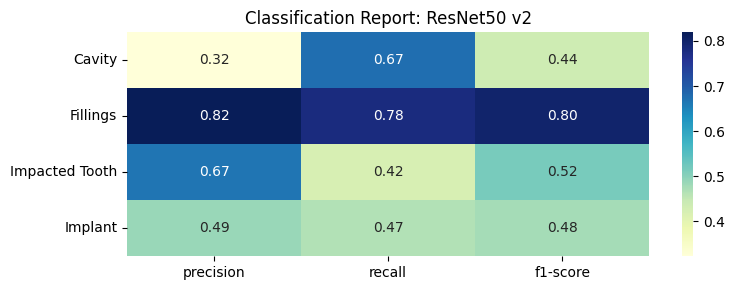

Overall Accuracy: 0.69 | Error: 0.31


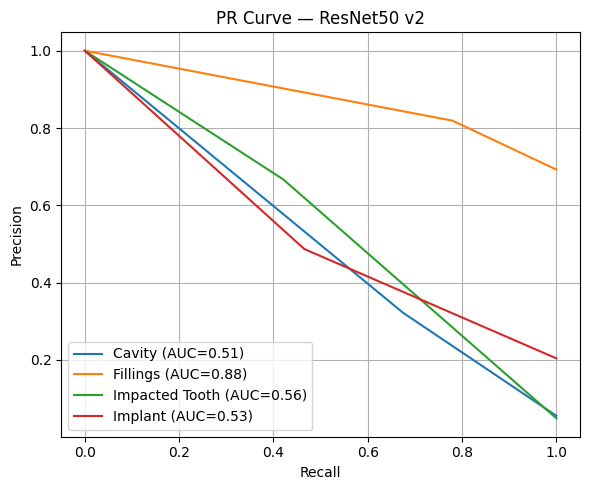

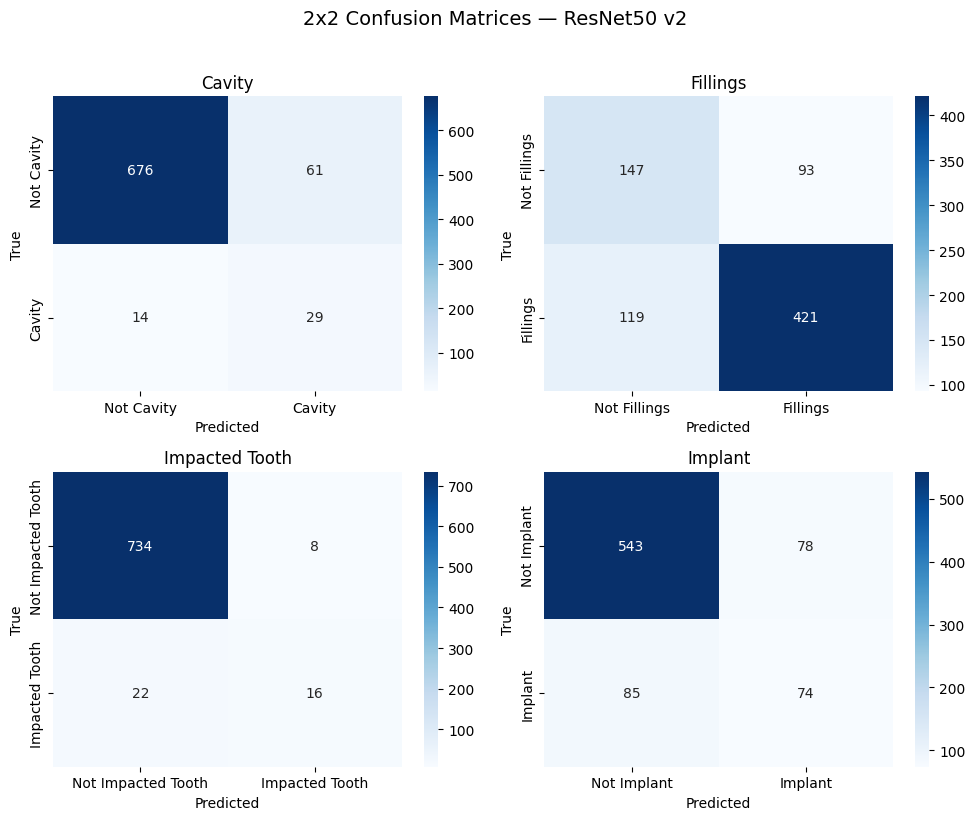

Classification Report — MobileNetV3 v2


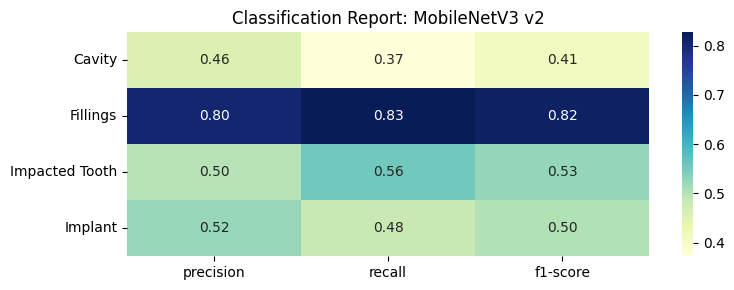

Overall Accuracy: 0.72 | Error: 0.28


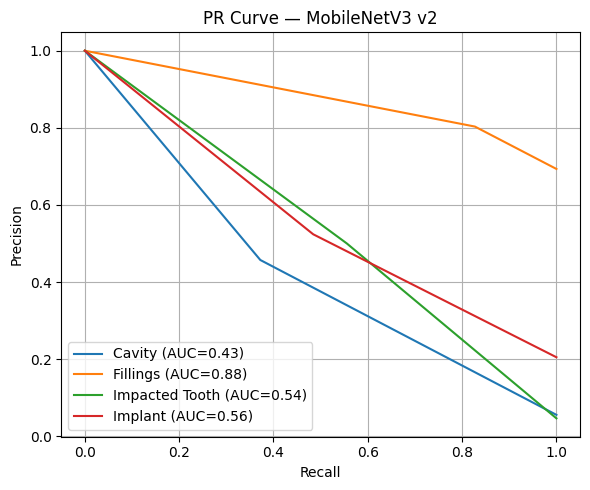

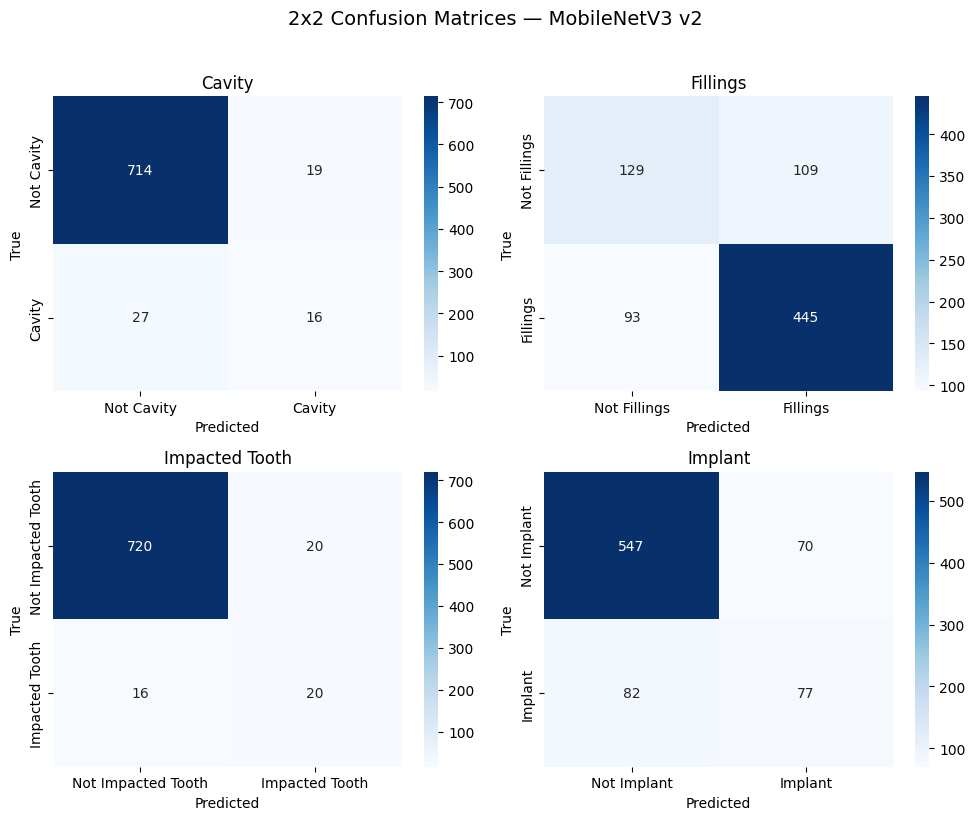

In [20]:
evaluate_model(model_resnet, "ResNet50 v2")
evaluate_model(model_mobilenet, "MobileNetV3 v2")


# Part 3: Focal Loss

## 3.1. Mount Google Drive and Set Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_DIR = "/content/drive/MyDrive/My Datasets"
DATA_DIR = os.path.join(BASE_DIR, "data_enhanced")
MODEL_DIR = os.path.join(DATA_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.2. Imports and Class Definitions

In [ ]:
import torch
import torchvision
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
class2idx = {c: i for i, c in enumerate(CLASSES)}
num_classes = len(CLASSES)


## 3.3. Annotation Loading and Dataset Class

In [ ]:
def load_annotations(csv_path, img_dir, class2idx):
    df = pd.read_csv(csv_path)
    annots = {}
    for _, row in df.iterrows():
        fn = row['filename']
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        lbl = class2idx[row['class']]
        if bbox[2] <= bbox[0] or bbox[3] <= bbox[1]:
            continue
        annots.setdefault(fn, {'boxes': [], 'labels': []})
        annots[fn]['boxes'].append(bbox)
        annots[fn]['labels'].append(lbl)
    dataset = []
    for fn, data in annots.items():
        dataset.append({
            'image_path': os.path.join(img_dir, fn),
            'boxes': torch.tensor(data['boxes'], dtype=torch.float32),
            'labels': torch.tensor(data['labels'], dtype=torch.int64),
        })
    return dataset

class DentalDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(item['image_path']).convert("RGB")
        boxes = item['boxes']
        labels = item['labels']

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((boxes.shape[0],), dtype=torch.int64)
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return F.to_tensor(img), target

    def __len__(self):
        return len(self.data)

def get_transforms(train=True):
    def _transform(img, target):
        if train and torch.rand(1) < 0.5:
            img = F.hflip(img)
            w, _ = img.size
            boxes = target['boxes']
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target['boxes'] = boxes
        return img, target
    return _transform

def build_loader(split, batch_size=4):
    csv_path = os.path.join(DATA_DIR, split, '_annotations.csv')
    img_dir = os.path.join(DATA_DIR, split)
    data = load_annotations(csv_path, img_dir, class2idx)
    dataset = DentalDataset(data, transforms=get_transforms(split == 'train'))
    return DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'), collate_fn=lambda x: tuple(zip(*x)))


## 3.4. Build and Modify Models with Focal Loss

In [ ]:
import torch.nn.functional as F_nn

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    log_probs = F_nn.log_softmax(inputs, dim=-1)
    probs = torch.exp(log_probs)
    targets_onehot = torch.zeros_like(log_probs).scatter(1, targets.unsqueeze(1), 1)

    ce_loss = -targets_onehot * log_probs
    focal_term = (1 - probs) ** gamma

    loss = alpha * focal_term * ce_loss
    loss = loss.sum(dim=1)

    return loss.mean() if reduction == "mean" else loss.sum()

def fastrcnn_loss_focal(class_logits, box_regression, labels, regression_targets):
    classification_loss = focal_loss(class_logits, labels, alpha=0.25, gamma=2.0)

    pos_inds = torch.where(labels > 0)[0]
    if pos_inds.numel() == 0:
        box_loss = torch.tensor(0.0, device=class_logits.device)
    else:
        labels_pos = labels[pos_inds]
        box_loss = F_nn.smooth_l1_loss(
            box_regression[pos_inds, labels_pos],
            regression_targets[pos_inds],
            beta=1.0,
            reduction="sum"
        ) / labels.numel()

    return {'loss_classifier': classification_loss, 'loss_box_reg': box_loss}

def build_model(base='resnet'):
    if base == 'resnet':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    else:
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=None)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    # 👇 Patch Focal Loss
    model.roi_heads.fastrcnn_loss = fastrcnn_loss_focal
    return model


## 3.5. Training

In [ ]:
train_loader = build_loader("train")
valid_loader = build_loader("valid")

model_resnet = build_model("resnet")
model_mobilenet = build_model("mobilenet")

optimizer_r = torch.optim.SGD(model_resnet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer_m = torch.optim.SGD(model_mobilenet.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    model_resnet.train()
    model_mobilenet.train()
    total_loss_r = 0.0
    total_loss_m = 0.0

    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # ResNet
        loss_r = sum(model_resnet(imgs, targets).values())
        optimizer_r.zero_grad(); loss_r.backward(); optimizer_r.step()
        total_loss_r += loss_r.item()

        # MobileNet
        loss_m = sum(model_mobilenet(imgs, targets).values())
        optimizer_m.zero_grad(); loss_m.backward(); optimizer_m.step()
        total_loss_m += loss_m.item()

    print(f"📉 ResNet Avg Loss: {total_loss_r / len(train_loader):.4f} | 📉 MobileNet Avg Loss: {total_loss_m / len(train_loader):.4f}")



🔁 Epoch 1/10


KeyboardInterrupt: 

## 3.6. Saving the model

In [ ]:
torch.save(model_resnet.state_dict(), os.path.join(MODEL_DIR, "fasterrcnn_resnet50_focal.pth"))
torch.save(model_mobilenet.state_dict(), os.path.join(MODEL_DIR, "fasterrcnn_mobilenetv3_focal.pth"))
print("✅ Models saved.")


✅ Models saved.


## 3.7. Loading

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn

def build_model_focal(base='resnet'):
    if base == 'resnet':
        model = fasterrcnn_resnet50_fpn(weights=None)
    else:
        model = fasterrcnn_mobilenet_v3_large_fpn(weights=None)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 👇 Patch with focal loss
    model.roi_heads.fastrcnn_loss = fastrcnn_loss_focal
    return model.to(device)

# Load models
model_resnet = build_model_focal('resnet')
model_resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, "fasterrcnn_resnet50_focal.pth"), map_location=device))
model_resnet.eval()

model_mobilenet = build_model_focal('mobilenet')
model_mobilenet.load_state_dict(torch.load(os.path.join(MODEL_DIR, "fasterrcnn_mobilenetv3_focal.pth"), map_location=device))
model_mobilenet.eval()


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 44.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## 3.8. Evaluation


Classification Report — ResNet50 (Focal)


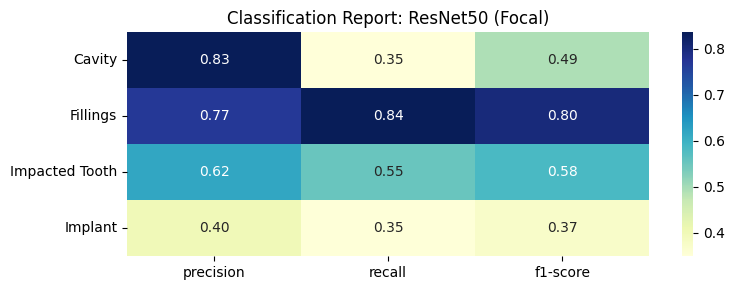

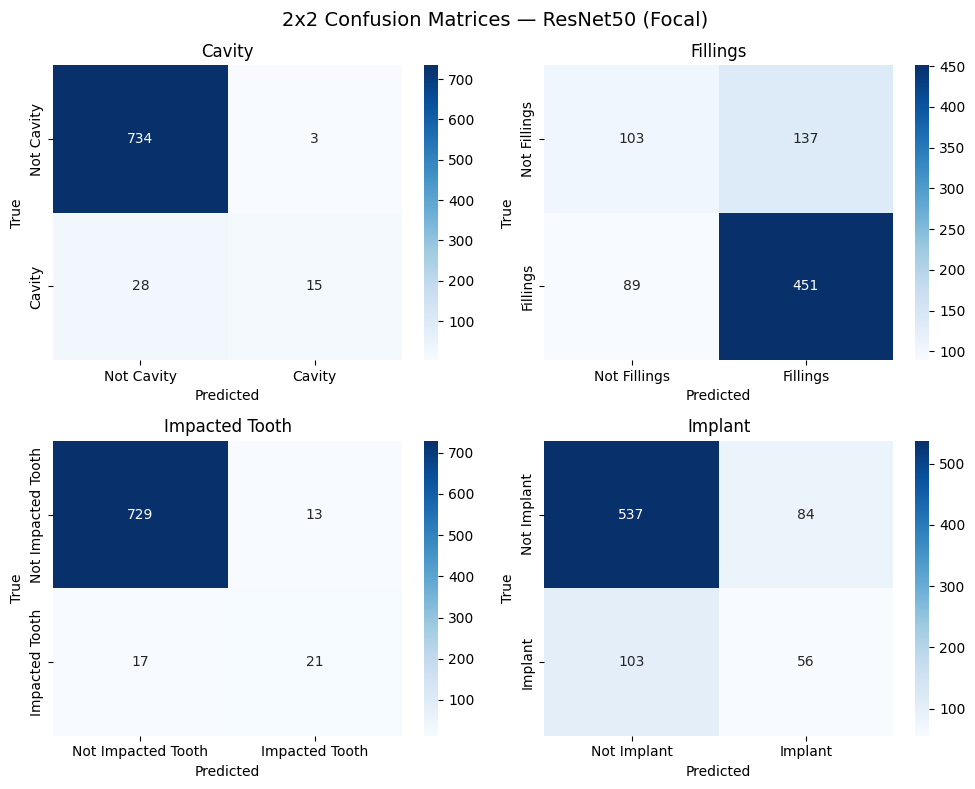

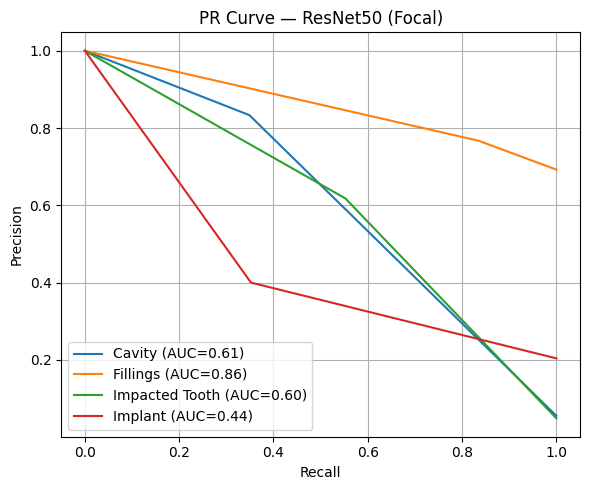

Overall Accuracy: 0.70 | Error: 0.30

Classification Report — MobileNetV3 (Focal)


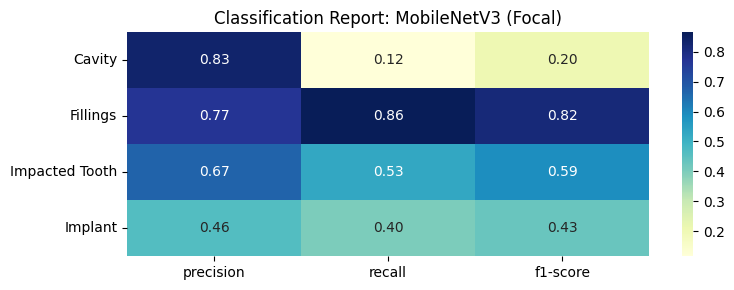

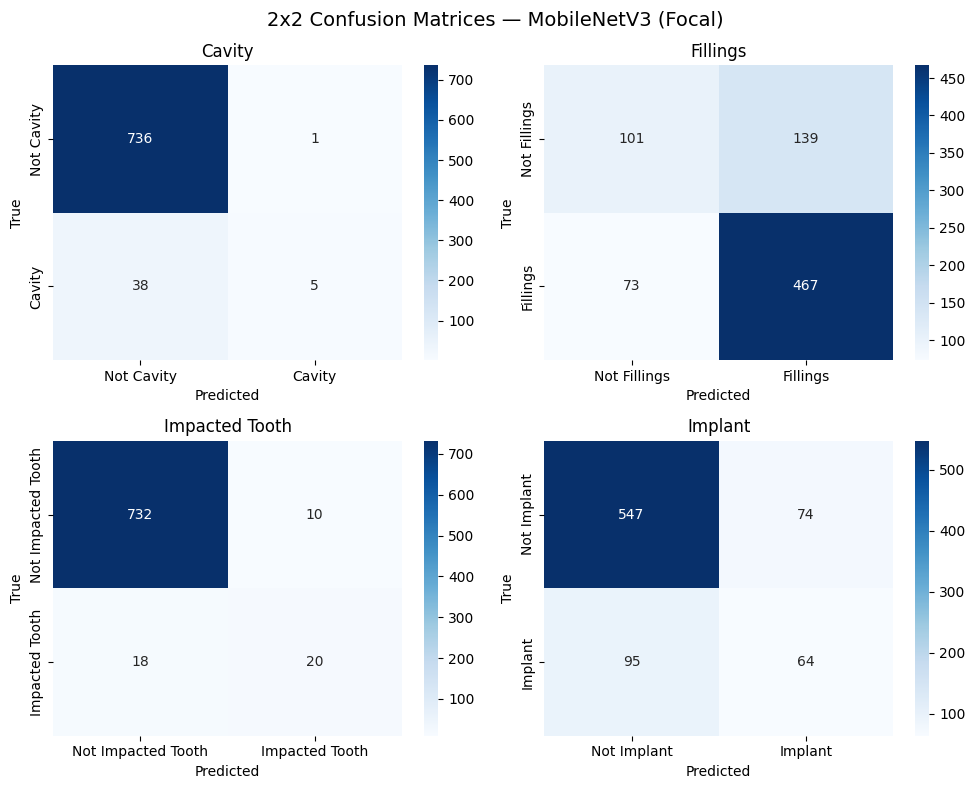

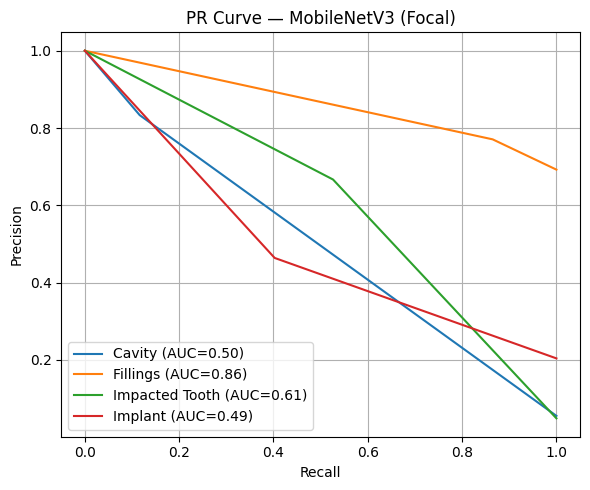

Overall Accuracy: 0.71 | Error: 0.29


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model, model_name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                pred_labels = outputs[i]['labels'].cpu().numpy().tolist()
                true_labels = targets[i]['labels'].cpu().numpy().tolist()
                n = min(len(pred_labels), len(true_labels))
                all_preds.extend(pred_labels[:n])
                all_targets.extend(true_labels[:n])

    # 📄 Classification Report
    print(f"\nClassification Report — {model_name}")
    report = classification_report(all_targets, all_preds, labels=list(range(1, len(CLASSES))), target_names=CLASSES[1:], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 3))
    sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Classification Report: {model_name}")
    plt.tight_layout()
    plt.show()

    # 📊 2x2 Confusion Matrices
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx + 1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx + 1 else 0 for p in all_preds])
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape != (2, 2): cm = np.array([[0, 0], [0, 0]])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f"Not {cls_name}", cls_name],
                    yticklabels=[f"Not {cls_name}", cls_name],
                    ax=axes[idx])
        axes[idx].set_title(f"{cls_name}")
        axes[idx].set_xlabel("Predicted"); axes[idx].set_ylabel("True")
    plt.suptitle(f"2x2 Confusion Matrices — {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 📈 Precision-Recall Curve
    plt.figure(figsize=(6, 5))
    for idx, cls_name in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx+1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx+1 else 0 for p in all_preds])
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{cls_name} (AUC={pr_auc:.2f})")

    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True)
    plt.title(f"PR Curve — {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🎯 Overall Accuracy
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(all_targets, all_preds)
    print(f"Overall Accuracy: {acc:.2f} | Error: {1 - acc:.2f}")

# 🔍 Evaluate Both Models
evaluate_model(model_resnet, "ResNet50 (Focal)")
evaluate_model(model_mobilenet, "MobileNetV3 (Focal)")


## 3.9. Testing for single image


📸 Image: 0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg
✅ Ground Truth Labels     : ['Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings', 'Fillings']
🔵 ResNet Predicted Labels : ['Fillings', 'Fillings', 'Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Fillings', 'Fillings', 'Fillings', 'Implant', 'Fillings', 'Fillings', 'Fillings']


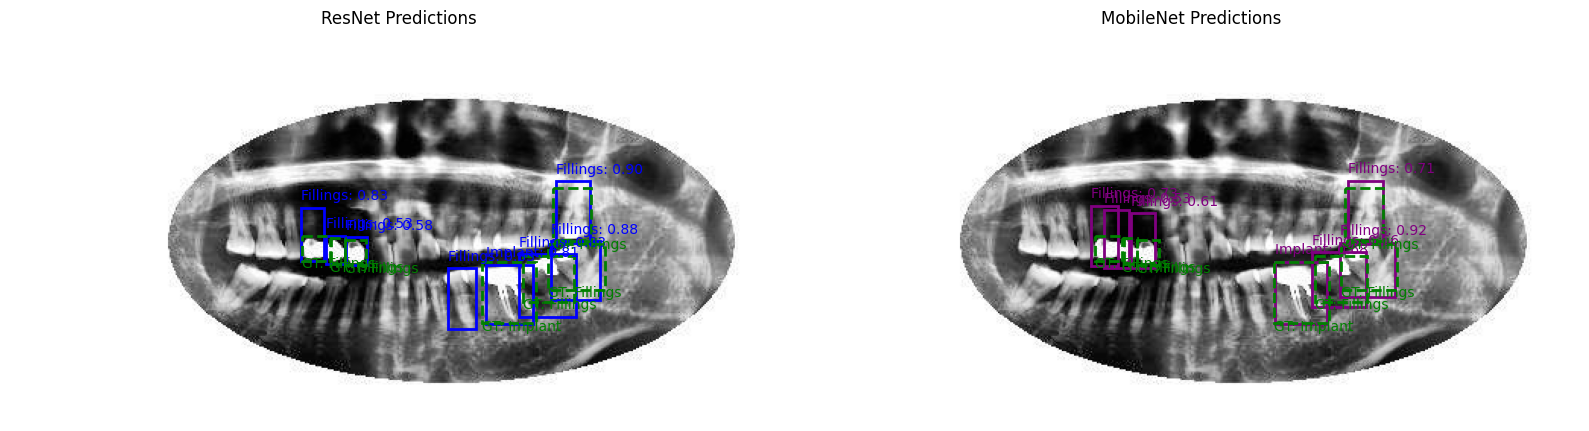


📸 Image: 0151_jpg.rf.5b81ded715693313866503d5a4da1639.jpg
✅ Ground Truth Labels     : ['Cavity', 'Cavity']
🔵 ResNet Predicted Labels : ['Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Fillings', 'Fillings', 'Fillings']


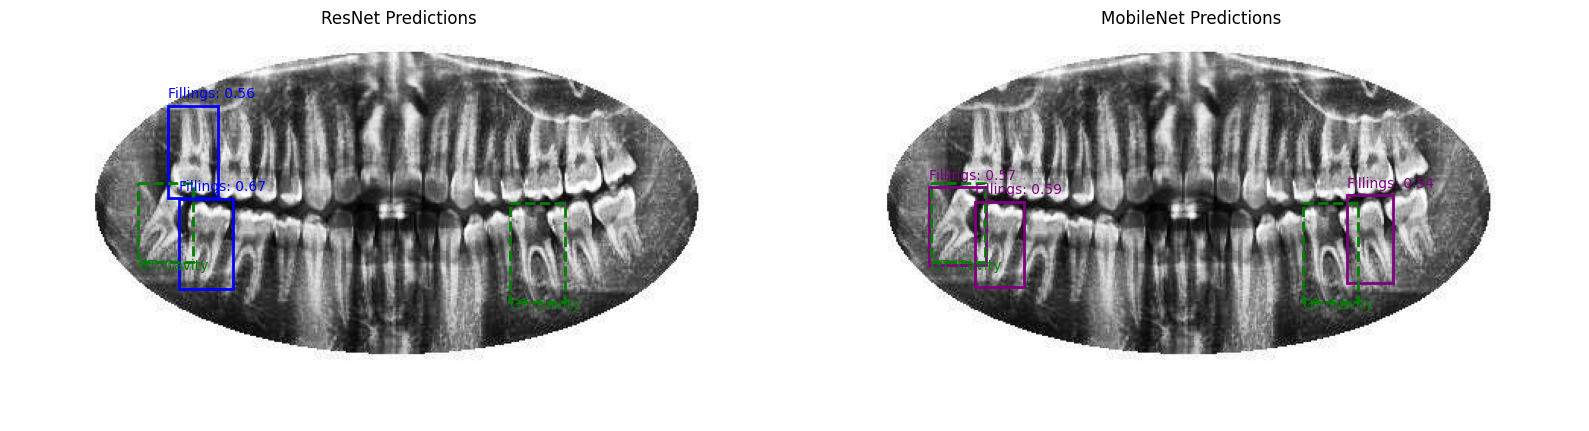


📸 Image: 0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg
✅ Ground Truth Labels     : ['Fillings', 'Fillings', 'Fillings']
🔵 ResNet Predicted Labels : ['Fillings', 'Fillings', 'Fillings', 'Fillings']
🟣 MobileNet Predicted Labels: ['Fillings', 'Fillings', 'Fillings']


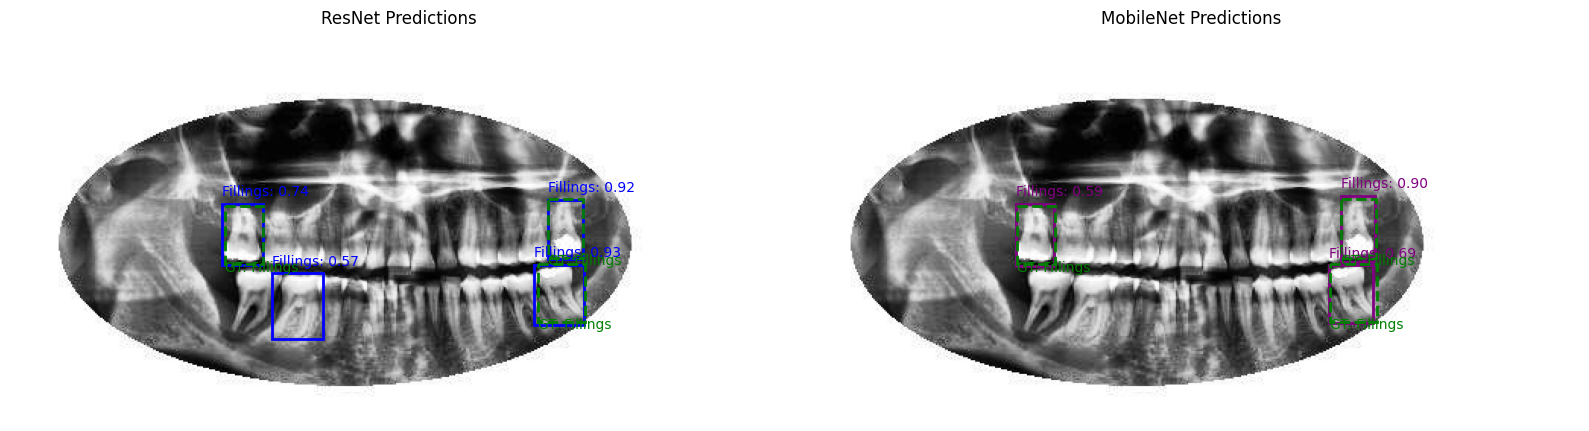


📸 Image: 0529_jpg.rf.d3cb17dddc3e9efd85e48c386feca1f2.jpg
✅ Ground Truth Labels     : ['Impacted Tooth']
🔵 ResNet Predicted Labels : ['Impacted Tooth', 'Impacted Tooth', 'Fillings', 'Impacted Tooth']
🟣 MobileNet Predicted Labels: []


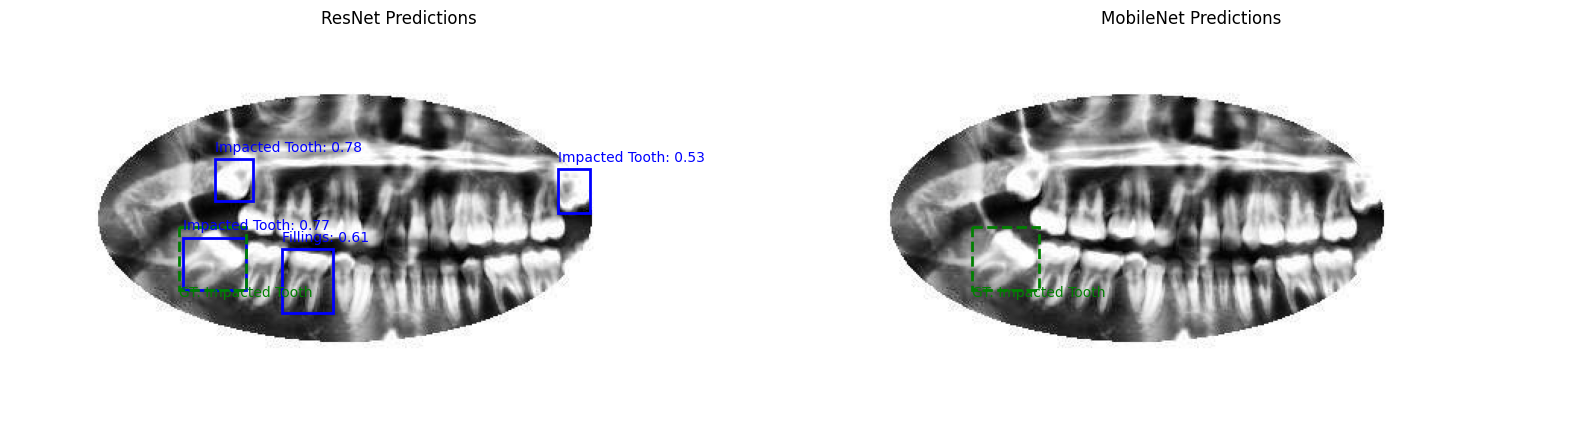

In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# 📌 Class names
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']

# 📁 Paths
ANNOTATION_CSV = "/content/drive/MyDrive/My Datasets/data_enhanced/test/_annotations.csv"
IMAGE_DIR = "/content/drive/MyDrive/My Datasets/data_enhanced/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load test annotations
df = pd.read_csv(ANNOTATION_CSV)

# 🔁 Load and preprocess image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(img), img  # tensor, original PIL

# 📦 Get ground-truth boxes + labels
def get_ground_truth(image_name):
    rows = df[df['filename'] == image_name]
    gts = []
    for _, row in rows.iterrows():
        bbox = [float(row['xmin']), float(row['ymin']), float(row['xmax']), float(row['ymax'])]
        label = row['class']
        gts.append({'bbox': bbox, 'label': label})
    return gts

# 🔍 Compare both models visually
def compare_models_on_image(image_name, threshold=0.5):
    image_path = os.path.join(IMAGE_DIR, image_name)
    ground_truth = get_ground_truth(image_name)

    img_tensor, img_pil = load_image(image_path)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        pred_resnet = model_resnet([img_tensor])[0]
        pred_mobilenet = model_mobilenet([img_tensor])[0]

    # 🎯 Predicted label names (filtered)
    pred_resnet_labels = [CLASSES[label] for label, score in zip(pred_resnet['labels'], pred_resnet['scores']) if score > threshold]
    pred_mobilenet_labels = [CLASSES[label] for label, score in zip(pred_mobilenet['labels'], pred_mobilenet['scores']) if score > threshold]
    gt_labels = [obj['label'] for obj in ground_truth]

    # 🖨️ Print result
    print(f"\n📸 Image: {image_name}")
    print("✅ Ground Truth Labels     :", gt_labels)
    print("🔵 ResNet Predicted Labels :", pred_resnet_labels)
    print("🟣 MobileNet Predicted Labels:", pred_mobilenet_labels)

    # 🖼️ Visualize predictions
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    titles = ['ResNet Predictions', 'MobileNet Predictions']
    preds = [pred_resnet, pred_mobilenet]
    colors = ['blue', 'purple']

    for ax, pred, title, color in zip(axs, preds, titles, colors):
        ax.imshow(img_pil.copy())

        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score < threshold:
                continue
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{CLASSES[label]}: {score:.2f}", color=color, fontsize=10)

        # Ground-truth boxes
        for gt in ground_truth:
            x1, y1, x2, y2 = gt['bbox']
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y2 + 5, f"GT: {gt['label']}", color='green', fontsize=10)

        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

compare_models_on_image("0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg")
compare_models_on_image("0151_jpg.rf.5b81ded715693313866503d5a4da1639.jpg")
compare_models_on_image("0168_jpg.rf.99cc9d1eae8cd16603df5ca3e11e4cf4.jpg")
compare_models_on_image("0529_jpg.rf.d3cb17dddc3e9efd85e48c386feca1f2.jpg")

# Part 4: Hard Negative Mining

## 4.1. Setup Code to Collect Hard Negatives

In [ ]:
def collect_hard_negatives(model, loader, iou_thresh=0.3, score_thresh=0.5, max_per_image=3):
    import torchvision.ops as ops
    hard_negatives = []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img_tensor, target, output in zip(images, targets, outputs):
                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']

                if len(pred_boxes) == 0:
                    continue

                ious = ops.box_iou(pred_boxes, gt_boxes)
                max_ious, _ = ious.max(dim=1)

                for i, iou in enumerate(max_ious):
                    if iou < iou_thresh and pred_scores[i] > score_thresh:
                        hard_negatives.append({
                            "image": img_tensor.cpu(),
                            "box": pred_boxes[i].cpu(),
                            "label": pred_labels[i].item(),
                            "score": pred_scores[i].item()
                        })
                        if len(hard_negatives) >= max_per_image:
                            break
    return hard_negatives

# Run on validation set and collect top false positives
hard_negatives = collect_hard_negatives(model_resnet, valid_loader)
print(f"🔍 Found {len(hard_negatives)} hard negatives.")


🔍 Found 0 hard negatives.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_hard_negative(hn):
    img = hn['image'].permute(1, 2, 0).numpy()
    box = hn['box']
    label = CLASSES[hn['label']]
    score = hn['score']

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=10)
    ax.set_title("Hard Negative")
    ax.axis('off')
    plt.show()

# Example:
show_hard_negative(hard_negatives[0])


IndexError: list index out of range

## 4.2. Add Hard Negatives to Your Train Set

In [ ]:
# Convert hard negatives to same format as normal data
def add_hard_negatives_to_dataset(hard_negatives, existing_data):
    for hn in hard_negatives:
        image_tensor = hn['image']
        box = hn['box'].unsqueeze(0)  # shape (1, 4)
        label = torch.tensor([0], dtype=torch.int64)  # background

        item = {
            'image_path': None,  # not used during __getitem__
            'image_tensor': image_tensor,  # used directly
            'boxes': box,
            'labels': label
        }
        existing_data.append(item)
    return existing_data


In [ ]:
class DentalDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.data[idx]

        if item.get('image_tensor') is not None:
            img = item['image_tensor']
        else:
            img = Image.open(item['image_path']).convert("RGB")
            img = F.to_tensor(img)

        boxes = item['boxes']
        labels = item['labels']

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((boxes.shape[0],), dtype=torch.int64)
        }

        if self.transforms:
            img_pil = F.to_pil_image(img)
            img, target = self.transforms(img_pil, target)
            img = F.to_tensor(img)

        return img, target

    def __len__(self):
        return len(self.data)


## 4.3. Combine and Rebuild Loader

In [ ]:
# Load base train set
train_csv = os.path.join(DATA_DIR, "train/_annotations.csv")
train_dir = os.path.join(DATA_DIR, "train")
train_data = load_annotations(train_csv, train_dir, class2idx)

# Add hard negatives
train_data_with_hn = add_hard_negatives_to_dataset(hard_negatives, train_data)

# Rebuild loader
train_dataset = DentalDataset(train_data_with_hn, transforms=get_transforms(train=True))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

print(f"✅ Train dataset size after HNM: {len(train_dataset)}")


✅ Train dataset size after HNM: 1075


## 4.4. Training

In [ ]:
num_epochs = 7

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")

    model_resnet.train()
    model_mobilenet.train()

    total_loss_r = 0.0
    total_loss_m = 0.0

    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # --- ResNet ---
        loss_dict_r = model_resnet(imgs, targets)
        loss_r = sum(loss for loss in loss_dict_r.values())
        optimizer_r.zero_grad()
        loss_r.backward()
        optimizer_r.step()
        total_loss_r += loss_r.item()

        # --- MobileNet ---
        loss_dict_m = model_mobilenet(imgs, targets)
        loss_m = sum(loss for loss in loss_dict_m.values())
        optimizer_m.zero_grad()
        loss_m.backward()
        optimizer_m.step()
        total_loss_m += loss_m.item()

    print(f"📉 ResNet Avg Loss: {total_loss_r / len(train_loader):.4f} | 📉 MobileNet Avg Loss: {total_loss_m / len(train_loader):.4f}")



🔁 Epoch 1/7
📉 ResNet Avg Loss: 0.4906 | 📉 MobileNet Avg Loss: 0.5406

🔁 Epoch 2/7
📉 ResNet Avg Loss: 0.7218 | 📉 MobileNet Avg Loss: 0.6852

🔁 Epoch 3/7
📉 ResNet Avg Loss: 0.7221 | 📉 MobileNet Avg Loss: 0.6842

🔁 Epoch 4/7
📉 ResNet Avg Loss: 0.7323 | 📉 MobileNet Avg Loss: 0.6865

🔁 Epoch 5/7
📉 ResNet Avg Loss: 0.7148 | 📉 MobileNet Avg Loss: 0.6806

🔁 Epoch 6/7
📉 ResNet Avg Loss: 0.7342 | 📉 MobileNet Avg Loss: 0.6908

🔁 Epoch 7/7
📉 ResNet Avg Loss: 0.7029 | 📉 MobileNet Avg Loss: 0.6715


## 4.5. Saving

In [ ]:
torch.save(model_resnet.state_dict(), os.path.join(MODEL_DIR, "fasterrcnn_resnet50_focal_hnm.pth"))
torch.save(model_mobilenet.state_dict(), os.path.join(MODEL_DIR, "fasterrcnn_mobilenetv3_focal_hnm.pth"))
print("✅ Saved HNM-trained models.")


✅ Saved HNM-trained models.


## 4.6. Loading

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────────────────────
# 2️⃣ Paths & Class Definitions
# ──────────────────────────────────────────────────────────────────────────────
BASE           = "/content/drive/MyDrive/My Datasets/data_enhanced"
MODEL_DIR      = os.path.join(BASE, "models")
ADV_MODEL_DIR  = os.path.join(BASE, "advanced_models")

CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
# ──────────────────────────────────────────────────────────────────────────────

# ──────────────────────────────────────────────────────────────────────────────
# 3️⃣ Load Faster R-CNN (ResNet50) with Focal+HNM Weights
# ──────────────────────────────────────────────────────────────────────────────
model_resnet = fasterrcnn_resnet50_fpn(weights=None)
in_feat_r = model_resnet.roi_heads.box_predictor.cls_score.in_features
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_feat_r, num_classes=len(CLASSES))
resnet_path = os.path.join(MODEL_DIR, "fasterrcnn_resnet50_focal_hnm.pth")
model_resnet.load_state_dict(torch.load(resnet_path, map_location=device))
model_resnet.to(device).eval()

# ──────────────────────────────────────────────────────────────────────────────
# 4️⃣ Load Faster R-CNN (MobileNetV3) with Focal+HNM Weights
# ──────────────────────────────────────────────────────────────────────────────
model_mobilenet = fasterrcnn_mobilenet_v3_large_fpn(weights=None)
in_feat_m = model_mobilenet.roi_heads.box_predictor.cls_score.in_features
model_mobilenet.roi_heads.box_predictor = FastRCNNPredictor(in_feat_m, num_classes=len(CLASSES))
mobilenet_path = os.path.join(MODEL_DIR, "fasterrcnn_mobilenetv3_focal_hnm.pth")
model_mobilenet.load_state_dict(torch.load(mobilenet_path, map_location=device))
model_mobilenet.to(device).eval()



Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 84.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

## 4.7. Evaluation

## 4.8. Testing for single image

# Part 5: Model Ensembling

## 5.1. Evaluation and Prediction Functions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_ensemble_on_test():
    model_resnet.eval()
    model_mobilenet.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs_r = model_resnet(images)
            outputs_m = model_mobilenet(images)

            for i in range(len(images)):
                labels_r = outputs_r[i]['labels'].cpu().numpy()
                scores_r = outputs_r[i]['scores'].cpu().numpy()
                labels_m = outputs_m[i]['labels'].cpu().numpy()
                scores_m = outputs_m[i]['scores'].cpu().numpy()

                # Ensemble predictions
                final_labels = []
                for lbl, score in zip(labels_r, scores_r):
                    if score > 0.5:
                        final_labels.append(lbl)
                for lbl, score in zip(labels_m, scores_m):
                    if score > 0.5:
                        final_labels.append(lbl)

                pred_labels = final_labels
                true_labels = targets[i]['labels'].cpu().numpy().tolist()
                n = min(len(pred_labels), len(true_labels))
                all_preds.extend(pred_labels[:n])
                all_targets.extend(true_labels[:n])

    # Report
    print("\n📄 Classification Report (Ensemble on Test Set)")
    report = classification_report(all_targets, all_preds, target_names=CLASSES[1:], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    plt.figure(figsize=(8, 3))
    sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report (Test Set - Ensemble)")
    plt.tight_layout()
    plt.show()

    # PR Curve
    plt.figure(figsize=(6, 5))
    for idx, cls in enumerate(CLASSES[1:]):
        y_true = np.array([1 if t == idx+1 else 0 for t in all_targets])
        y_pred = np.array([1 if p == idx+1 else 0 for p in all_preds])
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{cls} (AUC={pr_auc:.2f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve — Ensemble (Test Set)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## 5.2. Prepare Test DataLoader

In [ ]:
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
import os

def save_ensemble_predictions(test_loader, output_dir="ensemble_test_outputs", max_images=20):
    os.makedirs(output_dir, exist_ok=True)
    model_resnet.eval()
    model_mobilenet.eval()
    count = 0

    with torch.no_grad():
        for images, targets in test_loader:
            for i in range(len(images)):
                if count >= max_images:
                    return

                img_tensor = images[i].to(device)
                img_pil = TF.to_pil_image(images[i].cpu())

                pred_r = model_resnet([img_tensor])[0]
                pred_m = model_mobilenet([img_tensor])[0]

                # Combine predictions
                all_boxes = torch.cat([pred_r['boxes'], pred_m['boxes']], dim=0)
                all_scores = torch.cat([pred_r['scores'], pred_m['scores']], dim=0)
                all_labels = torch.cat([pred_r['labels'], pred_m['labels']], dim=0)

                keep = torchvision.ops.nms(all_boxes, all_scores, iou_threshold=0.5)
                final_boxes = all_boxes[keep]
                final_labels = all_labels[keep]
                final_scores = all_scores[keep]

                # Draw
                fig, ax = plt.subplots(1, 1, figsize=(8, 6))
                ax.imshow(img_pil)
                for box, label, score in zip(final_boxes, final_labels, final_scores):
                    if score < 0.5: continue
                    x1, y1, x2, y2 = box.cpu().numpy()
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                             linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1 - 5, f"{CLASSES[label]}: {score:.2f}", color='red', fontsize=10)

                # GT boxes
                for gt_box, gt_label in zip(targets[i]['boxes'], targets[i]['labels']):
                    x1, y1, x2, y2 = gt_box.cpu().numpy()
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                             linewidth=1, edgecolor='green', facecolor='none', linestyle='--')
                    ax.add_patch(rect)
                    ax.text(x1, y2 + 5, f"GT: {CLASSES[gt_label]}", color='green', fontsize=9)

                ax.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"ensemble_test_{count}.png"))
                plt.close()
                count += 1


## 5.3. Visual Comparison on Single Images

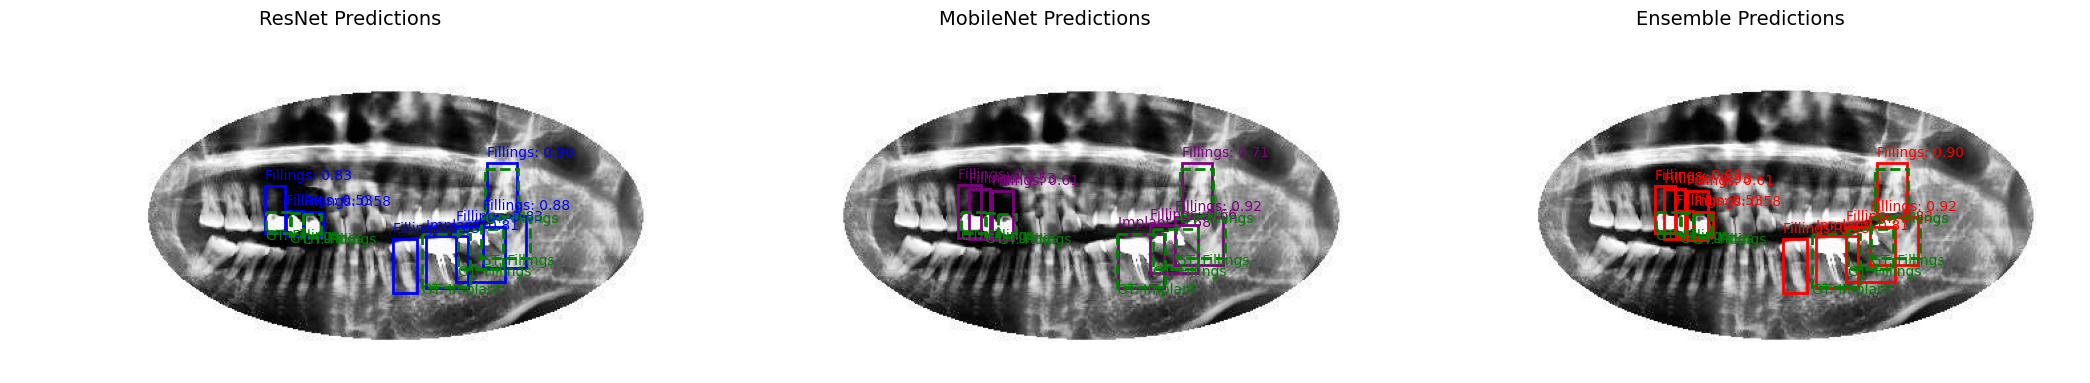

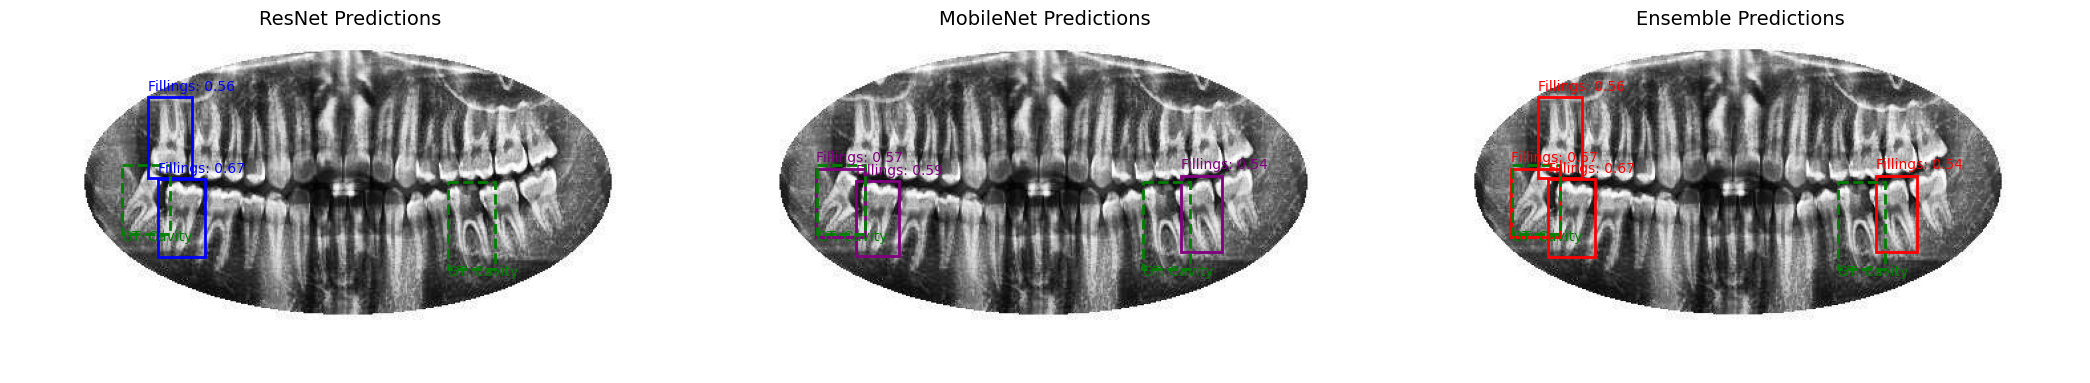

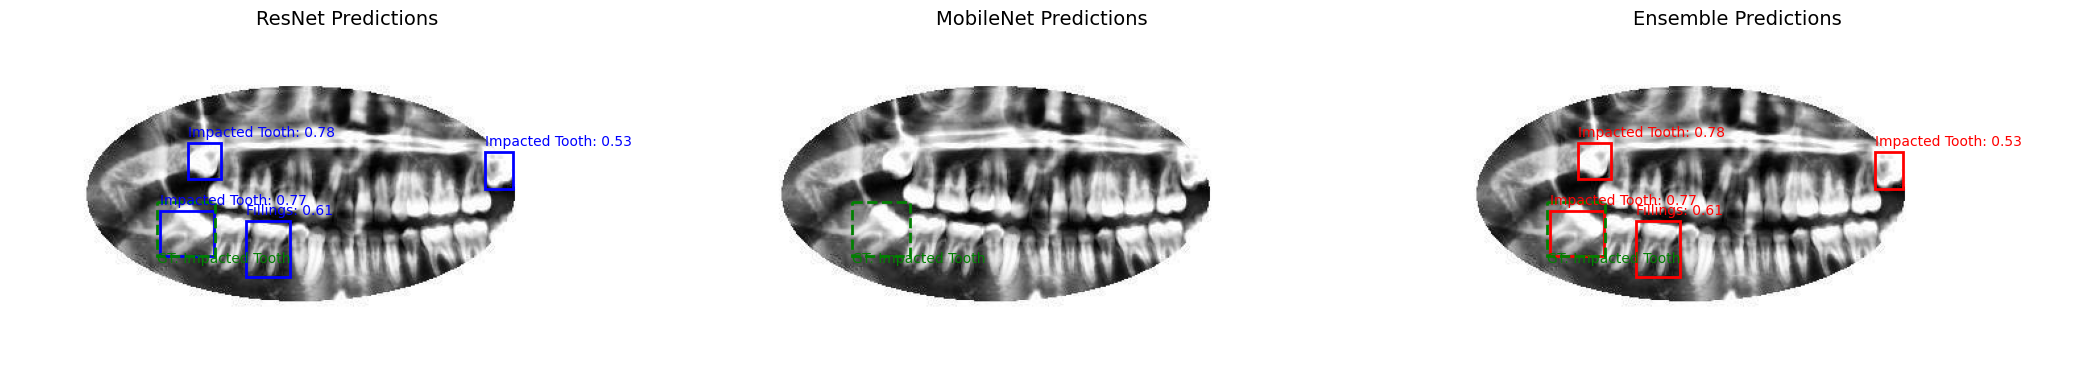

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# 📌 Class labels
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Paths
ANNOTATION_CSV = "/content/drive/MyDrive/My Datasets/data_enhanced/test/_annotations.csv"
IMAGE_DIR = "/content/drive/MyDrive/My Datasets/data_enhanced/test"
df = pd.read_csv(ANNOTATION_CSV)

# 🔁 Load image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(img), img

# ✅ Get ground truth
def get_ground_truth(image_name):
    rows = df[df['filename'] == image_name]
    gts = []
    for _, row in rows.iterrows():
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        label = row['class']
        gts.append({'bbox': bbox, 'label': label})
    return gts

# 📸 Compare ResNet, MobileNet, and Ensemble predictions
def compare_all_models(image_name, score_thresh=0.5):
    image_path = os.path.join(IMAGE_DIR, image_name)
    img_tensor, img_pil = load_image(image_path)
    img_tensor = img_tensor.to(device)
    ground_truth = get_ground_truth(image_name)

    with torch.no_grad():
        preds_r = model_resnet([img_tensor])[0]
        preds_m = model_mobilenet([img_tensor])[0]

    # 🔁 Ensemble
    all_boxes = torch.cat([preds_r['boxes'], preds_m['boxes']], dim=0)
    all_scores = torch.cat([preds_r['scores'], preds_m['scores']], dim=0)
    all_labels = torch.cat([preds_r['labels'], preds_m['labels']], dim=0)
    keep = torchvision.ops.nms(all_boxes, all_scores, iou_threshold=0.5)
    ensemble_boxes = all_boxes[keep]
    ensemble_scores = all_scores[keep]
    ensemble_labels = all_labels[keep]

    # 📊 Plotting
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    titles = ['ResNet', 'MobileNet', 'Ensemble']
    preds = [preds_r, preds_m,
             {'boxes': ensemble_boxes, 'scores': ensemble_scores, 'labels': ensemble_labels}]
    colors = ['blue', 'purple', 'red']

    for ax, pred, title, color in zip(axs, preds, titles, colors):
        ax.imshow(img_pil.copy())
        ax.set_title(f"{title} Predictions", fontsize=14)

        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score < score_thresh: continue
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{CLASSES[label]}: {score:.2f}", color=color, fontsize=10)

        # Ground truth (green)
        for gt in ground_truth:
            x1, y1, x2, y2 = gt['bbox']
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y2 + 5, f"GT: {gt['label']}", color='green', fontsize=10)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 🧪 Example usage:
compare_all_models("0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg")
compare_all_models("0151_jpg.rf.5b81ded715693313866503d5a4da1639.jpg")
compare_all_models("0529_jpg.rf.d3cb17dddc3e9efd85e48c386feca1f2.jpg")


## 5.4. Run Final Evaluation and Save Predictions

In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

# 📌 Class labels
CLASSES = ['__background__', 'Cavity', 'Fillings', 'Impacted Tooth', 'Implant']
class2idx = {c: i for i, c in enumerate(CLASSES)}

class DentalXrayDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        csv_path = os.path.join(image_dir, "_annotations.csv")
        self.df = pd.read_csv(csv_path)
        self.image_files = self.df["filename"].unique()

        # Build annotations
        self.annotations = {}
        for _, row in self.df.iterrows():
            fname = row['filename']
            bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
            label = class2idx[row['class']]
            if fname not in self.annotations:
                self.annotations[fname] = {'boxes': [], 'labels': []}
            self.annotations[fname]['boxes'].append(bbox)
            self.annotations[fname]['labels'].append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert("RGB")

        ann = self.annotations.get(fname, {'boxes': [], 'labels': []})
        boxes = torch.tensor(ann['boxes'], dtype=torch.float32)
        labels = torch.tensor(ann['labels'], dtype=torch.int64)

        # Safe fallback for invalid samples
        if boxes.shape[0] == 0:
            boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
            labels = torch.tensor([0], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64),
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return F.to_tensor(image), target

# ✅ Reuse your dataset class and collate_fn
def collate_fn(batch):
    return tuple(zip(*batch))

# ✅ Path to test set
TEST_DIR = "/content/drive/MyDrive/My Datasets/data_enhanced/test"

# ✅ Create test dataset and loader
test_dataset = DentalXrayDataset(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)



📄 Classification Report (Ensemble on Test Set)


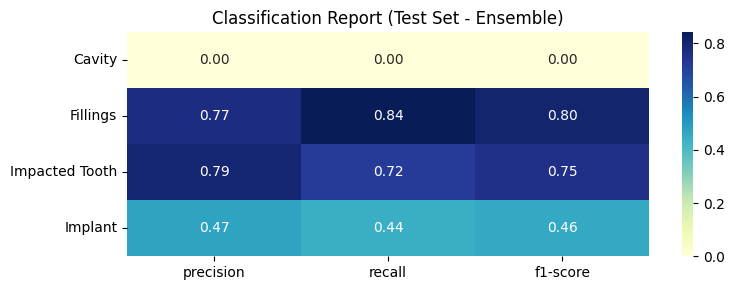

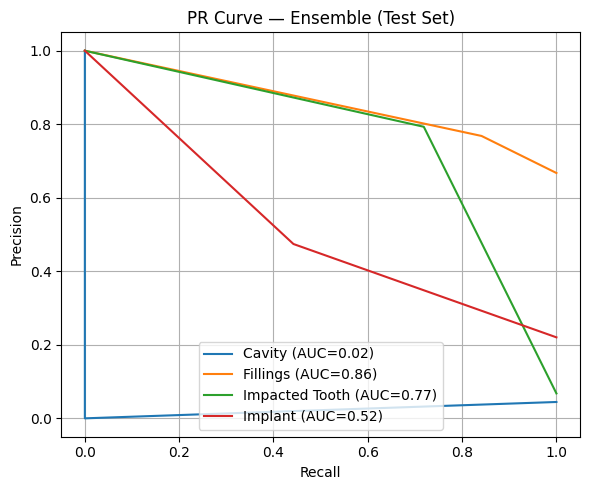

In [ ]:
evaluate_ensemble_on_test()
save_ensemble_predictions(test_loader, max_images=25)
